# Possible to-do's and discussion points:
1. [Which annotations to keep?](#different-polymorphism-annotations)
2. [Should we treshold based on the total allele number?](#distribution-across-the-genes)
3. Should we discard pieces of the reference sequence where we have contributions from single sequences and have no mutations present?
4. If yes to 3, what whould be the treshold? Positions occupied by just 1 sequence? Or not more than one gene?

- Add alpha7 dup - IS NOT IN THE DATABASE

# GnomAD analysis
# Library import

In [1]:
from pathlib import Path
import os
import numpy
import pandas

In [2]:
from Bio import AlignIO
from Bio.Seq import Seq
from Bio.SeqUtils import seq1

In [3]:
from collections import Counter, defaultdict

In [4]:
from matplotlib import pyplot
import matplotlib
%matplotlib inline
matplotlib.style.use("ggplot")
matplotlib.rcParams["figure.figsize"] = (10, 10)

In [5]:
import plotly.express as px
import plotly.graph_objects as go

# Importing the files
The raw files come in two sets. One is from GnomAD v3 and the other from GnomAD v2. The second is present as a backup if the mapping to the protein sequence from v3 fails.

In [6]:
_folder_path = Path() / "Raw_data"
_raw_files = [x for x in os.listdir(_folder_path) if os.path.isfile(_folder_path / x)]
_alternative_raw = [file for file in _raw_files if "2.1.1" in file]
_raw_files = list(set(_raw_files) - set(_alternative_raw))
print(*_raw_files, sep="\n")

gnomAD_v3.1.1_ENSG00000145888_2021_08_26_22_07_00_GLRA1.csv
gnomAD_v3.1.1_ENSG00000094755_2021_08_25_17_53_59_GABRP.csv
gnomAD_v3.1.1_ENSG00000149305_2021_08_25_17_56_50_5HT3B.csv
gnomAD_v3.1.1_ENSG00000109158_2021_08_25_17_49_50_GABRA4.csv
gnomAD_v3.1.2_ENSG00000135902_2021_10_26_19_04_55_CHRND.csv
gnomAD_v3.1.2_ENSG00000174343_2021_10_26_19_00_26_CHRNA9.csv
gnomAD_v3.1.1_ENSG00000109738_2021_08_26_22_08_17_GLRB.csv
gnomAD_v3.1.1_ENSG00000186297_2021_08_25_17_50_11_GABRA5.csv
gnomAD_v3.1.2_ENSG00000147432_2021_10_26_19_03_23_CHRNB3.csv
gnomAD_v3.1.1_ENSG00000102287_2021_08_25_17_51_00_GABRE.csv
gnomAD_v3.1.2_ENSG00000170175_2021_10_26_19_02_38_CHRNB1.csv
gnomAD_v3.1.1_ENSG00000101958_2021_08_26_22_07_30_GLRA2.csv
gnomAD_v3.1.1_ENSG00000183185_2021_08_25_17_54_54_GABRR3.csv
gnomAD_v3.1.1_ENSG00000145864_2021_08_25_17_51_32_GABRB2.csv
gnomAD_v3.1.1_ENSG00000186038_2021_08_25_17_57_43_5HT3E.csv
gnomAD_v3.1.1_ENSG00000101204_2021_09_06_14_25_11_CHRNA4.csv
gnomAD_v3.1.2_ENSG00000108556_202

We import the files as pandas DataFrame and add a column in which we track the gene of interest.

In [7]:
data = []
for file in _raw_files:
    data.append(pandas.read_csv(_folder_path / file))
    data[-1]["Gene"] = file.split(".")[-2].split("_")[-1]
data_alternative = []
for file in _alternative_raw:
    data_alternative.append(pandas.read_csv(_folder_path / file))
    data_alternative[-1]["Gene"] = file.split(".")[-2].split("_")[-1]

In [8]:
data[0]

,Chromosome,Position,rsIDs,Reference,Alternate,Source,Filters - exomes,Filters - genomes,Transcript,HGVS Consequence,...,Hemizygote Count Ashkenazi Jewish,Allele Count African/African-American,Allele Number African/African-American,Homozygote Count African/African-American,Hemizygote Count African/African-American,Allele Count European (non-Finnish),Allele Number European (non-Finnish),Homozygote Count European (non-Finnish),Hemizygote Count European (non-Finnish),Gene
0,5,151822609,rs1479218085,C,T,gnomAD Genomes,NaN,PASS,ENST00000274576.9,c.*64G>A,...,0,0,41438,0,0,3,68032,0,0,GLRA1
1,5,151822611,rs890814369,C,T,gnomAD Genomes,NaN,PASS,ENST00000274576.9,c.*62G>A,...,0,0,41440,0,0,5,68038,0,0,GLRA1
2,5,151822614,rs780429919,A,G,gnomAD Genomes,NaN,PASS,ENST00000274576.9,c.*59T>C,...,0,0,41384,0,0,2,68022,0,0,GLRA1
3,5,151822615,rs1007885241,G,C,gnomAD Genomes,NaN,PASS,ENST00000274576.9,c.*58C>G,...,0,2,41398,0,0,0,68032,0,0,GLRA1
4,5,151822631,rs557677019,C,T,gnomAD Genomes,NaN,PASS,ENST00000274576.9,c.*42G>A,...,0,0,41420,0,0,0,68036,0,0,GLRA1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,5,151924609,NaN,G,A,gnomAD Genomes,NaN,PASS,ENST00000274576.9,c.-60C>T,...,0,0,41434,0,0,1,68010,0,0,GLRA1
497,5,151924609,rs1358874817,G,T,gnomAD Genomes,NaN,PASS,ENST00000274576.9,c.-60C>A,...,0,0,41434,0,0,1,68010,0,0,GLRA1
498,5,151924615,rs930816700,A,C,gnomAD Genomes,NaN,PASS,ENST00000274576.9,c.-66T>G,...,0,0,41444,0,0,3,68042,0,0,GLRA1
499,5,151924615,rs930816700,A,G,gnomAD Genomes,NaN,PASS,ENST00000274576.9,c.-66T>C,...,0,0,41444,0,0,1,68042,0,0,GLRA1


Some columns are present only in a subset of files. We will keep them when joining the datasets, and introduce NaN where we have no data.

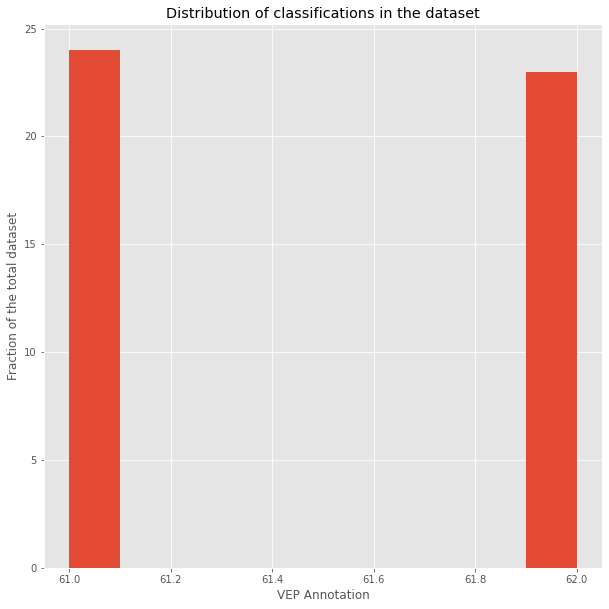

In [9]:
pyplot.hist([len(x.columns) for x in data])
pyplot.xlabel("VEP Annotation")
pyplot.ylabel("Fraction of the total dataset")
pyplot.title("Distribution of classifications in the dataset")
pyplot.show()

# Joining the datasets
We join both the main dataset and the alternative one.

In [10]:
dataset = pandas.concat(data, axis=0, join="outer", ignore_index=True)
dataset_alternative = pandas.concat(data_alternative, axis=0, join="outer", ignore_index=True)

In [11]:
dataset.shape

(28738, 62)

# Exploring the total dataset
## Different polymorphism annotations
For a complete description of the effect annotations see [the ensembl description](https://www.ensembl.org/info/genome/variation/prediction/predicted_data.html).
Only a subset of all the possible annotations is present. Here we focus only on the ones that result in a difference in the protein product. We collect the annotation labels into a list we can invoke later on.

In [12]:
dataset["VEP Annotation"].unique()

array(['3_prime_UTR_variant', 'stop_lost', 'missense_variant',
       'synonymous_variant', 'frameshift_variant', 'inframe_deletion',
       'splice_region_variant', 'intron_variant', 'stop_gained',
       'splice_donor_variant', '5_prime_UTR_variant',
       'splice_acceptor_variant', 'start_lost', 'inframe_insertion',
       'stop_retained_variant', nan, 'protein_altering_variant'],
      dtype=object)

In [13]:
_VEPs = ["missense_variant",
         "stop_gained",
         "splice_acceptor_variant",
         "splice_donor_variant",
         "frameshift_variant",
         "inframe_deletion",
         "inframe_insertion",
         "start_lost",
         "stop_lost",
         "protein_altering_variant"]

We see that the majority of the mutations of interest get classified into missense mutations (note that the visuals below only look at the labels of interest; though in the first graph the proportion is normalized to the size of the whole dataset, in the pie chart the total is equal to the number of the mutations of interest). As such, it might make sense to discuss if we would be better off disregarding all the other types of mutations just to make our life easier in terms of the analysis. In any event the proportions of different mutation types should probably be shown. 

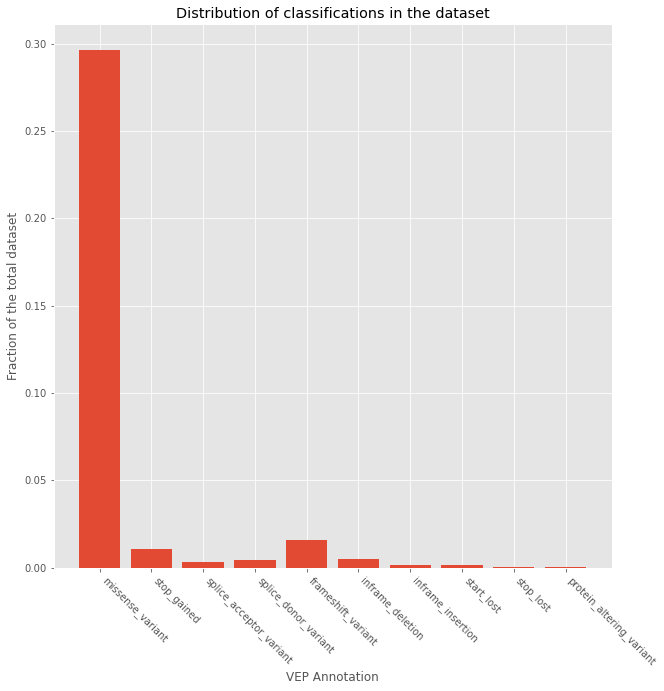

In [14]:
pyplot.bar(_VEPs, [sum(dataset["VEP Annotation"] == x)/dataset.shape[0]  for x in _VEPs])
pyplot.xticks(rotation=-45, horizontalalignment="left")
pyplot.xlabel("VEP Annotation")
pyplot.ylabel("Fraction of the total dataset")
pyplot.title("Distribution of classifications in the dataset")
pyplot.show()

C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  after removing the cwd from sys.path.


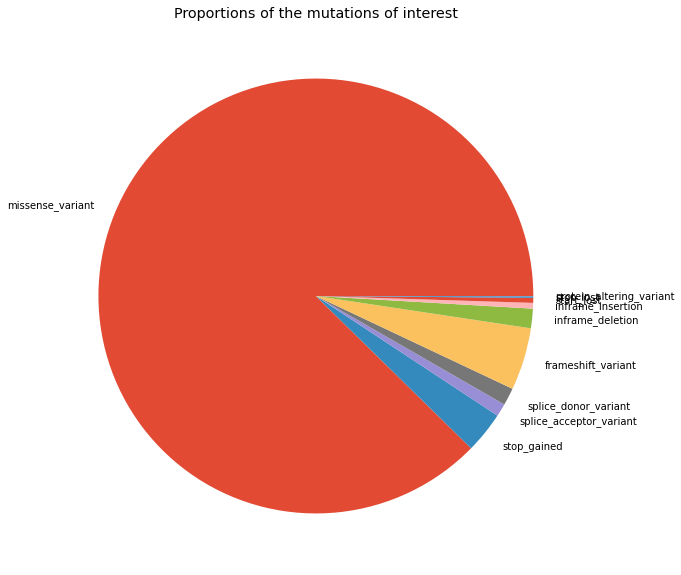

In [15]:
_counts = [sum(dataset["VEP Annotation"] == x)  for x in _VEPs]
_total = sum(_counts)
_counts = [x/_total for x in _counts]
pyplot.pie(_counts, labels=_VEPs)
pyplot.title("Proportions of the mutations of interest")
pyplot.show()

# Filtering

Before filtering anything else, we will discard all the data points where the total allele number deviates too much.

In [16]:
matplotlib.rcParams["figure.figsize"] = (30, 10)

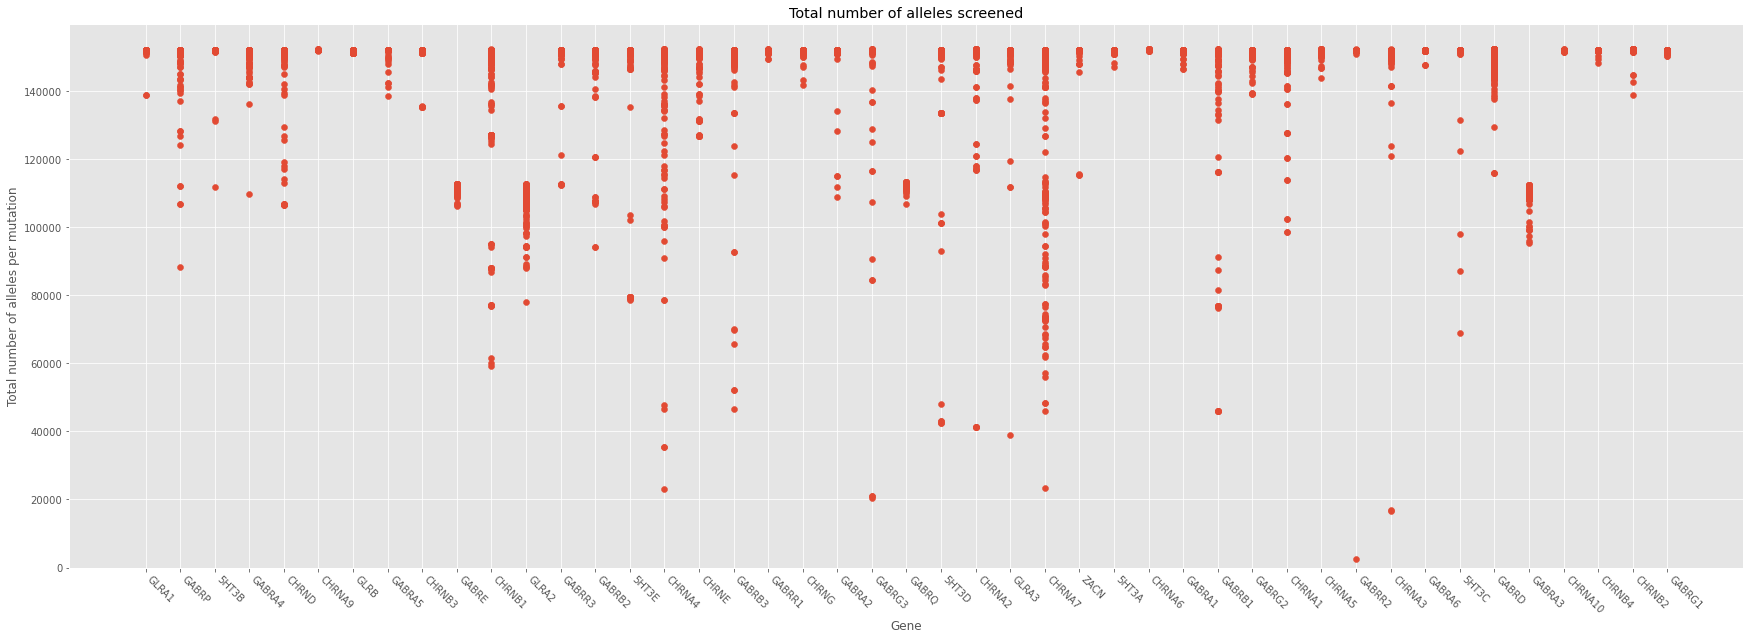

In [17]:
pyplot.scatter(dataset["Gene"], dataset["Allele Number"])
pyplot.xticks(rotation=-45, horizontalalignment="left")
pyplot.xlabel("Gene")
pyplot.ylabel("Total number of alleles per mutation")
pyplot.title("Total number of alleles screened")
ax = pyplot.gca()
ax.set_ylim([0, None])
pyplot.show()

In [18]:
_mean_af = dataset["Allele Number"].mean()
_std_af = dataset["Allele Number"].std()
print(f"Mean: {_mean_af}\nS. dev.: {_std_af}")

Mean: 148916.9469892099
S. dev.: 11639.162625345713


In [19]:
dataset = dataset[dataset.apply(lambda x: abs(x["Allele Number"] - _mean_af) < 3*_std_af, axis=1)]

Let's check again how the distribution looks like.

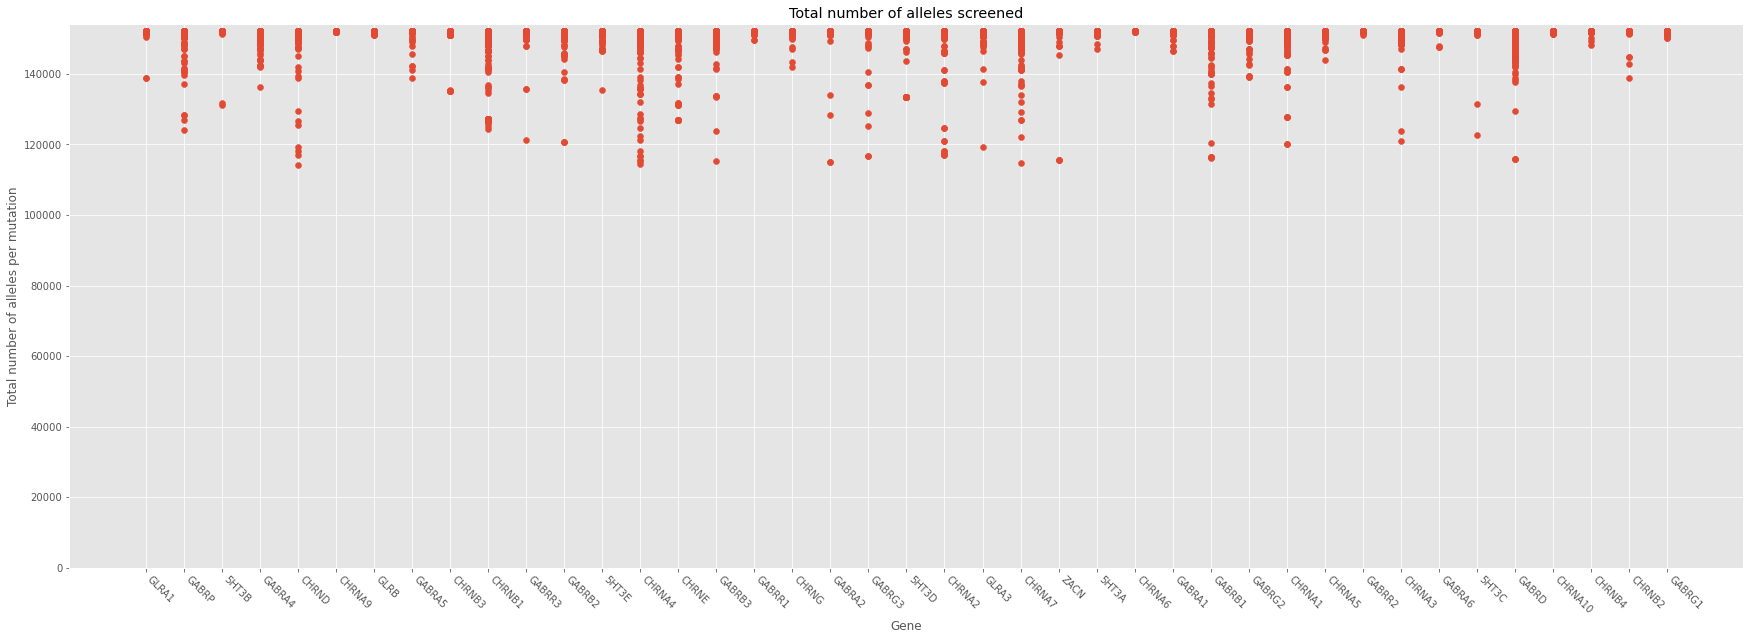

In [20]:
pyplot.scatter(dataset["Gene"], dataset["Allele Number"])
pyplot.xticks(rotation=-45, horizontalalignment="left")
pyplot.xlabel("Gene")
pyplot.ylabel("Total number of alleles per mutation")
pyplot.title("Total number of alleles screened")
ax = pyplot.gca()
ax.set_ylim([0, None])
pyplot.show()

We filter only for the GnomAD data.

In [21]:
dataset = dataset[dataset["Source"] == "gnomAD Genomes"]
dataset.reset_index(inplace=True)

In [22]:
matplotlib.rcParams["figure.figsize"] = (10, 10)

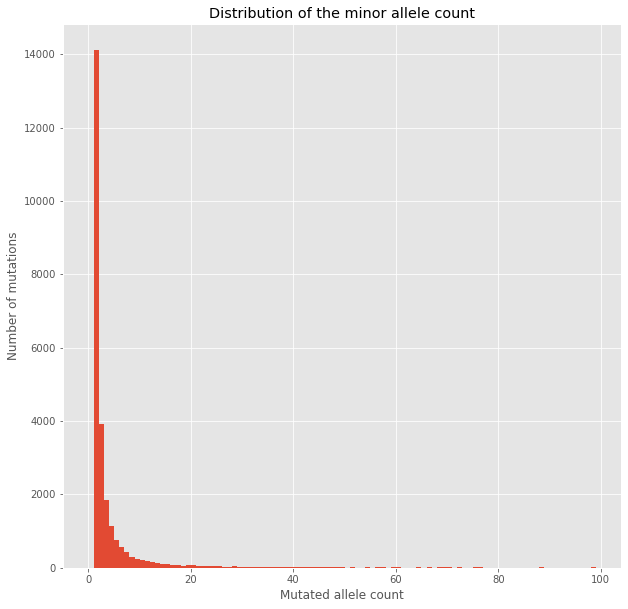

In [23]:
pyplot.hist(dataset["Allele Count"], bins=[x for x in range(0, 100)])
pyplot.xlabel("Mutated allele count")
pyplot.ylabel("Number of mutations")
pyplot.title("Distribution of the minor allele count")
pyplot.show()

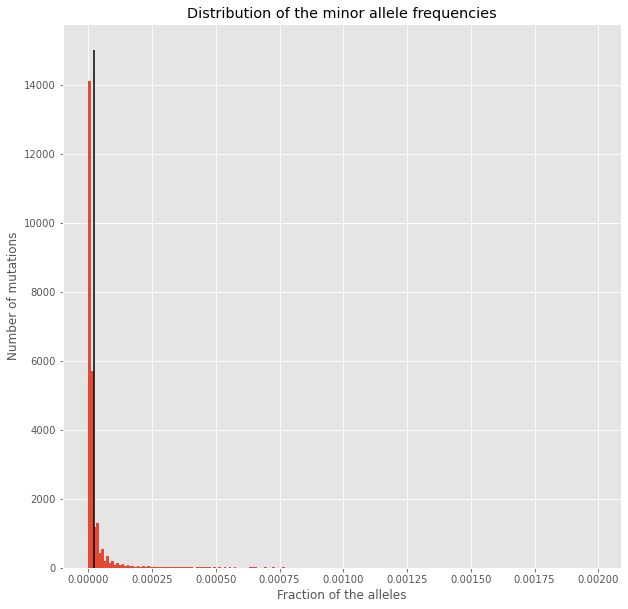

In [24]:
pyplot.hist(dataset["Allele Count"]/dataset["Allele Number"], bins=[x*0.00001 for x in range(0, 200)])
pyplot.vlines([0.00002], ymin=0, ymax=15000, colors="black")
pyplot.xlabel("Fraction of the alleles")
pyplot.ylabel("Number of mutations")
pyplot.title("Distribution of the minor allele frequencies")
pyplot.show()

For now we filter by including only variants present in at least 0.002 % of the population. The treshold is discussable, as the current one was chosen mainly just to perform some level of selection while also retaining a meaningful amount of data. Based on the majority of the sample sizes (see also below for a graphical depiction) the cutoff should in the majority of cases be in the range of 10 detected alleles.

We also retain just the columns of interest. Let's see the distribution of the annotations now.

In [25]:
subdata = dataset[dataset["Allele Count"]/dataset["Allele Number"] > 0.00002]
subdata = subdata[subdata["VEP Annotation"].isin(_VEPs)]
subdata

,index,Chromosome,Position,rsIDs,Reference,Alternate,Source,Filters - exomes,Filters - genomes,Transcript,...,Hemizygote Count Ashkenazi Jewish,Allele Count African/African-American,Allele Number African/African-American,Homozygote Count African/African-American,Hemizygote Count African/African-American,Allele Count European (non-Finnish),Allele Number European (non-Finnish),Homozygote Count European (non-Finnish),Hemizygote Count European (non-Finnish),Gene
25,25,5,151822692.0,rs752781486,T,C,gnomAD Genomes,NaN,PASS,ENST00000274576.9,...,0.0,0.0,41416.0,0.0,0.0,0.0,68040.0,0.0,0.0,GLRA1
27,27,5,151822698.0,rs200130685,C,T,gnomAD Genomes,NaN,PASS,ENST00000274576.9,...,0.0,1.0,41422.0,0.0,0.0,9.0,68036.0,0.0,0.0,GLRA1
33,33,5,151822727.0,rs141039714,C,A,gnomAD Genomes,NaN,PASS,ENST00000274576.9,...,0.0,42.0,41420.0,0.0,0.0,0.0,68034.0,0.0,0.0,GLRA1
34,34,5,151822728.0,rs1284734503,A,G,gnomAD Genomes,NaN,PASS,ENST00000274576.9,...,0.0,5.0,41430.0,0.0,0.0,0.0,68028.0,0.0,0.0,GLRA1
36,36,5,151822749.0,rs747623314,A,G,gnomAD Genomes,NaN,PASS,ENST00000274576.9,...,0.0,1.0,41448.0,0.0,0.0,3.0,68040.0,0.0,0.0,GLRA1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26804,28691,4,46123822.0,rs564894450,T,C,gnomAD Genomes,NaN,PASS,NaN,...,0.0,1.0,41424.0,0.0,0.0,0.0,68004.0,0.0,0.0,GABRG1
26812,28699,4,46123859.0,rs770228084,T,C,gnomAD Genomes,NaN,PASS,NaN,...,0.0,0.0,41454.0,0.0,0.0,5.0,68012.0,0.0,0.0,GABRG1
26813,28700,4,46123866.0,rs148202098,A,T,gnomAD Genomes,NaN,PASS,NaN,...,0.0,6.0,41398.0,0.0,0.0,18.0,68006.0,0.0,0.0,GABRG1
26818,28705,4,46123877.0,rs140068403,G,T,gnomAD Genomes,NaN,PASS,NaN,...,0.0,4.0,41424.0,0.0,0.0,29.0,68012.0,0.0,0.0,GABRG1


If we look at the distribution of mutations across the annotation labels as before, we see that the distribution has become even more skewed towards the missense variants.

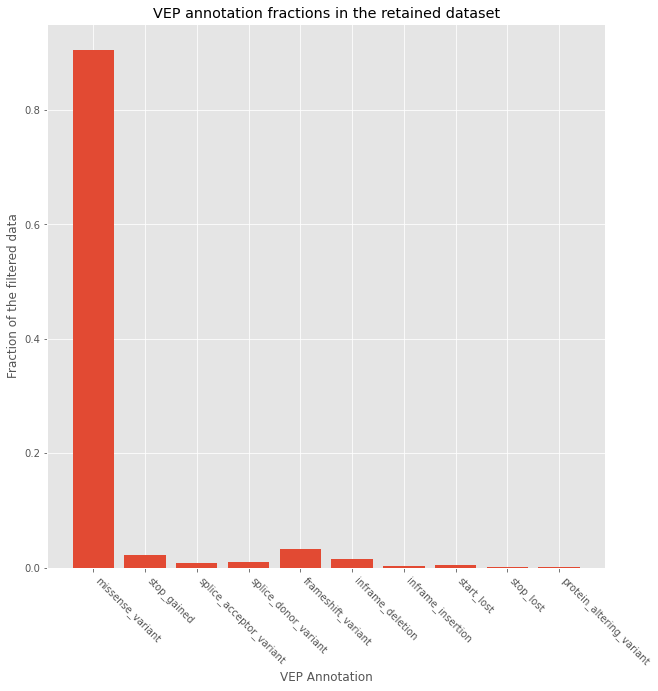

In [26]:
pyplot.bar(_VEPs, [sum(subdata["VEP Annotation"] == x)/subdata.shape[0]  for x in _VEPs])
pyplot.xticks(rotation=-45, horizontalalignment="left")
pyplot.xlabel("VEP Annotation")
pyplot.ylabel("Fraction of the filtered data")
pyplot.title("VEP annotation fractions in the retained dataset")
pyplot.show()

# Distribution across the genes
First we just look at the number of different polymorphisms detected for each gene.

In [27]:
matplotlib.rcParams["figure.figsize"] = (30, 10)

In [28]:
_genes = subdata["Gene"].unique()
_values = pandas.DataFrame({"Gene": _genes, "Value": [sum(subdata["Gene"] == x)/subdata.shape[0]  for x in _genes]})
_values.sort_values(by="Value", ascending=False, inplace=True, ignore_index=True)

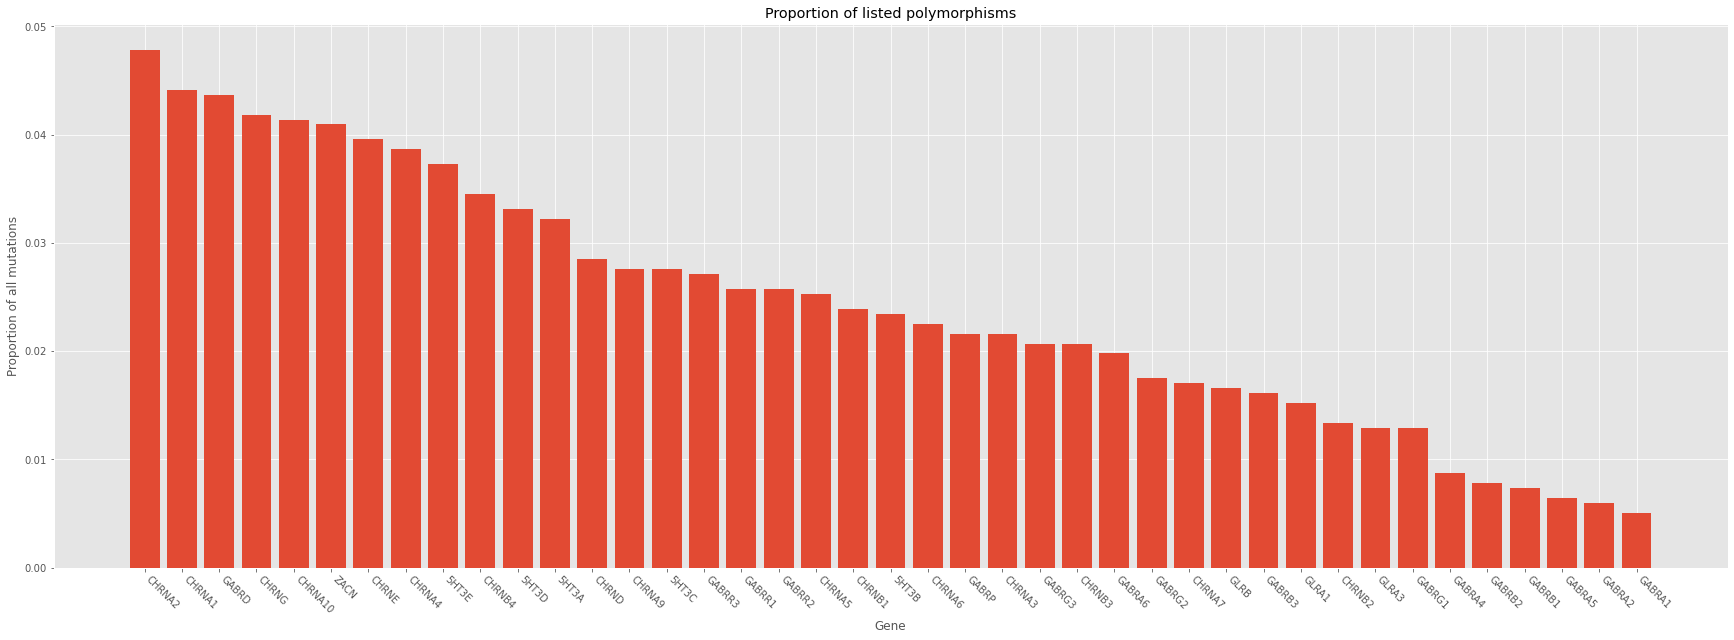

In [29]:
pyplot.bar(_values["Gene"], _values["Value"])
pyplot.xticks(rotation=-45, horizontalalignment="left")
pyplot.xlabel("Gene")
pyplot.ylabel("Proportion of all mutations")
pyplot.title("Proportion of listed polymorphisms")
pyplot.show()

We might want to discard some samples where total allele number is lower than some set treshold, as these might become the possible outliers in later statistics.

Next we look at the allele counts across all the mutations for single genes to get a feeling for which genes drive the statistical power in our sample. 

In [30]:
_values["Allele Count"] = [sum(subdata["Allele Count"][subdata["Gene"] == x]) for x in _values["Gene"]]
_values.sort_values(by="Allele Count", ascending=False, inplace=True, ignore_index=True)

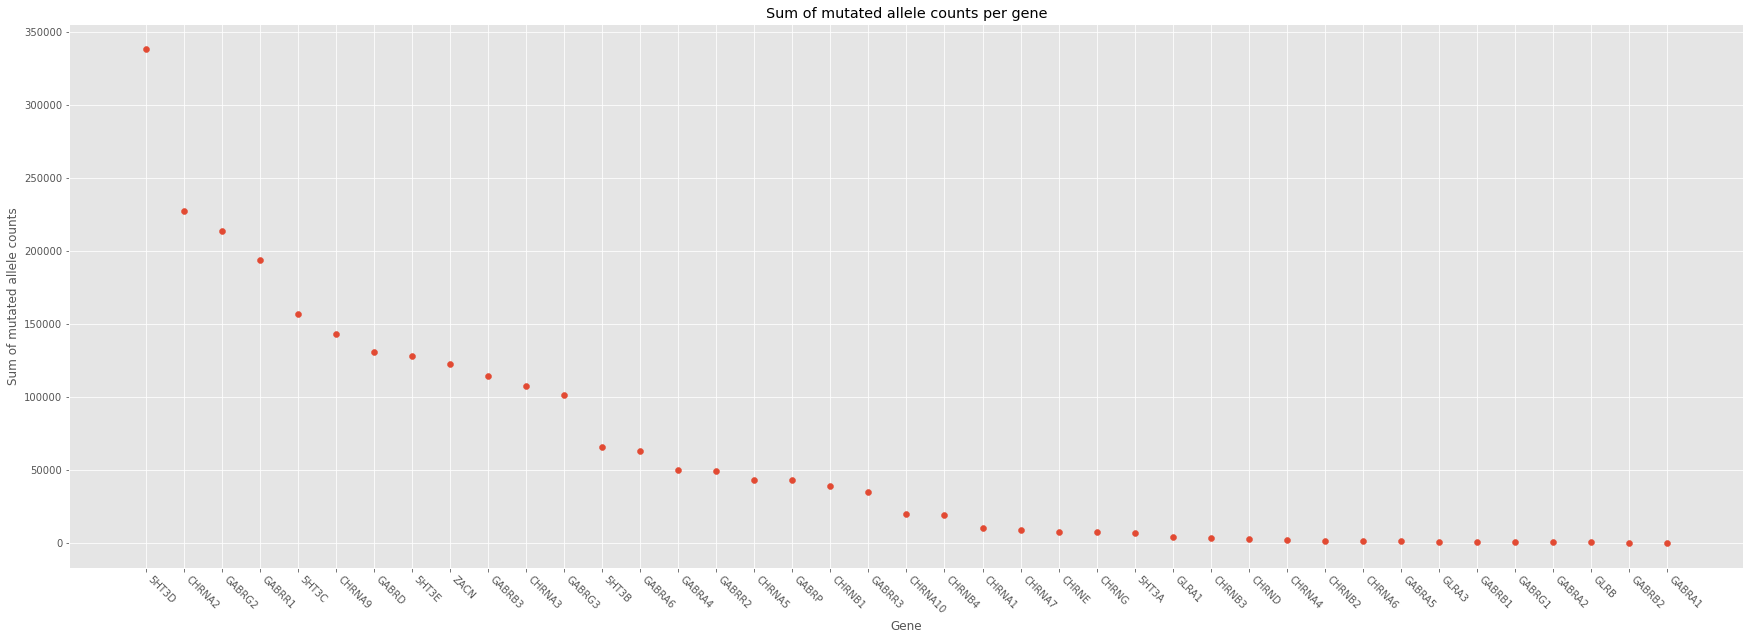

In [31]:
pyplot.scatter(_values["Gene"], _values["Allele Count"])
pyplot.xticks(rotation=-45, horizontalalignment="left")
pyplot.xlabel("Gene")
pyplot.ylabel("Sum of mutated allele counts")
pyplot.title("Sum of mutated allele counts per gene")
pyplot.show()

# Extracting the AA number from missense variants
We extracted the numbering of amino acid from `Protein Sequence` column. Then we used UniProt for determining the lengths of all proteins and normalized the position of amino acids to the full protein lengths. For a more in-depth analysis we would need an alignment.

We then look at the relative positions of the mutations for each gene separately by plotting the histograms one by one.

In [32]:
missense = subdata[subdata["VEP Annotation"] == "missense_variant"]
missense["AA Number"] = missense["Protein Consequence"].str.extract(r"[a-zA-Z]([0-9]+)[a-zA-Z]").astype("int32")
missense.reset_index(inplace=True)

C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [33]:
missense["AA Relative"] = 0
# Lengths are taken from UniProt
lengths = {
    "GABRA3": 492,
    "GABRA1": 456,
    "CHRNA3": 505,
    "GABRP": 440,
    "CHRNA4": 627,
    "GLRA2": 452,
    "GABRE": 506,
    "GABRA4": 554, 
    "GLRB": 497,
    "GABRR2": 465,
    "GABRG2": 467,
    "CHRNA2": 529,
    "CHRNA1": 482,
    "GLRA3": 464,
    "GABRA6": 453,
    "GABRB2": 512,
    "GLRA1": 457,
    "GABRR1": 479,
    "CHRNA6": 494,
    "5HT3B": 441,
    "GABRA2": 451,
    "GABRG1": 465,
    "GABRB1": 474,
    "GABRB3": 473,
    "5HT3A": 478,
    "CHRNA5": 468,
    "5HT3C": 447,
    "GABRG3": 467,
    "GABRR3": 467,
    "5HT3E": 456,
    "5HT3D": 454,
    "GABRA5": 462,
    "ZACN": 412,
    "GABRD": 452,
    "GABRQ": 632,
    "CHRNE": 493,
    "CHRNB4": 498,
    "CHRNA10": 450,
    "CHRND": 517,
    "CHRNB3": 458,
    "CHRNB2": 502,
    "CHRNB1": 501,
    "CHRNA9": 479,
    "CHRNA7": 502,
    "CHRNG": 517,
}
for gene in missense["Gene"].unique():
    missense["AA Relative"][missense["Gene"] == gene] = missense["AA Number"][missense["Gene"] == gene] / lengths[gene]

C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda\lib\site-packages\pandas\core\generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

In [ ]:
for gene in missense["Gene"].unique():
    pyplot.hist(missense["AA Relative"][missense["Gene"] == gene], bins=[x*0.01 for x in range(0, 101)], density=True)
    pyplot.xlabel("Relative position in the gene sequence")
    pyplot.ylabel("Number of mutations in 1 % of the sequence")
    pyplot.title(gene)
    pyplot.show()

# Mapping to a common alignment

## Producing the alignment
The alignment was produced through predicted structures by AlphaFold. The sequences used in the prediction are human reference sequences from UniProt, so the predicted structures should be complete. After fetching all the structures, these were imported into MOE session, where they were aligned. First, a global `optimized for superposition` alignment was performed. After that, sequence of the domain between TM3 and TM4 was separately aligned with `sequence only alignment` option. This part of structures is highly mobile, but is also less important for the comparison.The sequence before the first beta sheet was aligned with the help of known structures. 

Afterwards extra sequences were added for the proteins which had an unmappable mutations. This was necessary as the reference sequence for a lot of mutations is not the main sequence on UniProt. 

## Using the alignment

In [35]:
alignment = AlignIO.read("Alignment.aln", "clustal")

In [36]:
print(alignment)

Alignment with 179 rows and 1014 columns
--------------------------------------------...--- sp_P14867_GBRA1_
--------------------------------------------...--- GABRA1
--------------------------------------------...--- GABRA1_02
--------------------------------------------...--- GABRA1_03
--------------------------------------------...--- GABRA1_04
--------------------------------------------...--- GABRA1_05
--------------------------------------------...--- sp_P47869_GBRA2_
--------------------------------------------...--- GABRA2
--------------------------------------------...--- GABRA2_02
--------------------------------------------...--- GABRA2_03
--------------------------------------------...--- GABRA2_04
--------------------------------------------...--- sp_P34903_GBRA3_
----------------------MIITQTSHCYMTSLGILFLINI...--- GABRA3
--------------------------------------------...--- sp_P48169_GBRA4_
--------------------------------------------...--- GABRA4
----------------------------

We create a class to encapsulate the alignment and pack in it all the functions we would need for interacting with it.

The current functions are:
1. `convert_to_reference` ==> given name of the sequence, amino acid code and number it finds the amino acid in the sequence and returns the position of it in the full reference alignment.
2. `find_reference` ==> searches the amino acid through all the available isoforms of a gene by calling `convert_to_reference` on all the isoforms of a given gene and giving the first positive return.
3. `filter_sequence` ==> shortens the sequence by discarding the segments where either only one sequence or a signle gene has sequence present. In reality the class retains the full alignment but just produces a mapping for new numbering.
4.  `convert_to_filtered` ==> given the sequential number in the full alignment it returns the position in the filtered sequence. If the position was discarded it gives -1.
5. `aa_to_filtered` ==> given gene, amino acid code and numbering in the gene sequence it returns the position in the filtered sequence.

In [368]:
class Alignment:
    def __init__(self, alignment_file) -> None:
        self._alignment = AlignIO.read(alignment_file, "clustal")
        self._sequences = {sequence.id: sequence for sequence in self._alignment}
        self.alignment_subunits = self._sequences.keys()
    
    def convert_to_reference(self, id, acid, number):
        """
        Returns the position in the reference sequence (STARTING FROM 1) if found, else -1.
        The provided number also must start the amino acid count with 1.
        """
        if len(acid) == 3:
            acid = seq1(acid)

        sequence = self._sequences[id]

        # Edge case if the number is higher than the length of the sequence
        if number > len(str(sequence.seq).replace("-", "")):
            return -1

        i = 0
        for j, residue in enumerate(sequence):
            if residue != "-":
                i = i+1
                if i == number:
                    if residue == acid:
                        return j+1
                    else:
                        return -1

    def find_reference(self, gene, aacid, number):
        """
        Goes through all the internal isoforms of the selected gene and runs a reference run
        till it finds a match. Else it returns -1.
        """
        subunits = pandas.Series([sub for sub in self.alignment_subunits if gene in sub])
        result = subunits.apply(lambda x: self.convert_to_reference(x, aacid, number))
        return -1 if sum(result == -1) == len(result) else result[result != -1].iloc[0]
    
    def filter_sequence(self, group_isoforms=False):
        """
        Discards the positions of the alignment which are in the middle of 3 consequtive single-sequence occupied alignment subsequence.
        If group_isoforms is true it considers hits on multiple isoforms of the same gene as 1 hit. 
        """
        # self._original_sequences = self._sequences
        # self._original_alignment = self._alignment

        if group_isoforms:
            genes = pandas.Series([key for key in self._sequences.keys() if not "_" in key])
            # Note we pad the sequence with one 1 on each side. This is used just in the creation of the mask so we can properly process the first and last value
            sequence_count = numpy.pad(numpy.array([numpy.array([[y != "-" for y in ali_class._sequences[key]] for key in ali_class._sequences.keys() if gene in key]).any(axis=0) for gene in genes]).sum(axis=0), (1, 1), "constant", constant_values=1)
        else:
            sequence_count = numpy.array([1] + [len(self._alignment[:, i].replace("-", "")) for i in range(0, len(self._alignment[0]))] + [1])
        
        mask = numpy.array([(x > 1) or (y > 1) or (z > 1) for x, y, z in zip(sequence_count, sequence_count[1:], sequence_count[2:])])
        
        self.precomputed_filter = []
        j = 1
        for i, mask_value in enumerate(mask):
            if mask_value:
                self.precomputed_filter.append(j)
                j += 1
            else:
                self.precomputed_filter.append(-1)
    
    def convert_to_filtered(self, position):
        """"
        Takes the position in the reference sequence and converts it to the filtered reference position.
        If the position got discarded through filtering it returns -1.
        """
        return self.precomputed_filter[int(position)]

    def aa_to_filtered(self, gene, aacid, number):
        """
        Converts the amino acid to the filtered amino acid sequence using find_reference and convert_to_filtered.
        """
        referenced = self.find_reference(gene, aacid, number)
        if referenced != -1:
            referenced = self.convert_to_filtered(referenced)
        return referenced

    def reference_to_aa(self, position, gene):
        """
        Takes the position and returns the tuple containing the amino acid and sequential position on the given gene.
        """
        # slice the gene sequence at the position and take everything before it
        # check if the last amino acid is "-"
        # remove "-"
        # length
        sequence = self._sequences[gene][:position]
        if sequence[-1] == "-":
            return ("-", -1)
        return sequence[-1], len(str(sequence.seq).replace("-", ""))

We initiate the alignment class on our alignment and test it on a positive and negative examples. Then we apply it over the dataset.

In [369]:
ali_class = Alignment("Alignment.aln")
print(f'This should return 88: {ali_class.find_reference("GABRA1", "T", 20)}')
print(f'This should return -1: {ali_class.find_reference("GABRA1", "T", 23)}')

This should return 88: 88
This should return -1: -1


In [370]:
missense["AA Referenced"] = missense.apply(lambda x: ali_class.find_reference(x["Gene"], x["Protein Consequence"].split(".")[1][0:3], x["AA Number"]), axis=1)

C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



How many of the amino acids we failed to map?

In [371]:
print(sum(missense["AA Referenced"] == -1))
print(sum(missense["AA Referenced"] == -1) / missense.shape[0])

# Check also NaN-s just in case they were introduced - in that case something in the class is not working properly
print(sum(missense["AA Referenced"].isna()))

28
0.014227642276422764
0


For some SNPs the change in reference genome assembly changed the protein change assignment to an incorrect one. We use the GnomAD v2 assignments in the cases where there is an entry present. Where this also doesn't yield the correct assignment we use the alternative alignments to see if the mutation might have been mapped onto a non-main transcript.

In [372]:
for i in range(0, missense.shape[0]-1):
    if missense.iloc[i]["AA Referenced"] == -1:
        if missense.iloc[i]["rsIDs"] is None:
            x = dataset_alternative[(dataset_alternative["Gene"] == missense.iloc[i]["Gene"]) & (dataset_alternative["Transcript Consequence"] == missense.iloc[i]["Transcript Consequence"])]
        else:
            x = dataset_alternative[(dataset_alternative["Gene"] == missense.iloc[i]["Gene"]) & (dataset_alternative["rsIDs"] == missense.iloc[i]["rsIDs"])]
        if not x.empty and x["Protein Consequence"].any():
            missense.at[i, "AA Referenced"] = ali_class.find_reference(missense.iloc[i]["Gene"],
                                                    x["Protein Consequence"].str.split(".").values.tolist()[0][1][0:3],
                                                    x["Protein Consequence"].str.extract(r"[a-zA-Z]([0-9]+)[a-zA-Z]").astype("int32").values.tolist()[0][0])

In [373]:
print(sum(missense["AA Referenced"] == -1))
print(sum(missense["AA Referenced"] == -1) / missense.shape[0])

13
0.0066056910569105695


We managed to reduce the number of non-mapped mutations significantly. We could live with 19 if they are somewhat distributed across several genes and the total pool of mutations is high enough. 

Let's see the distribution throught the genes.

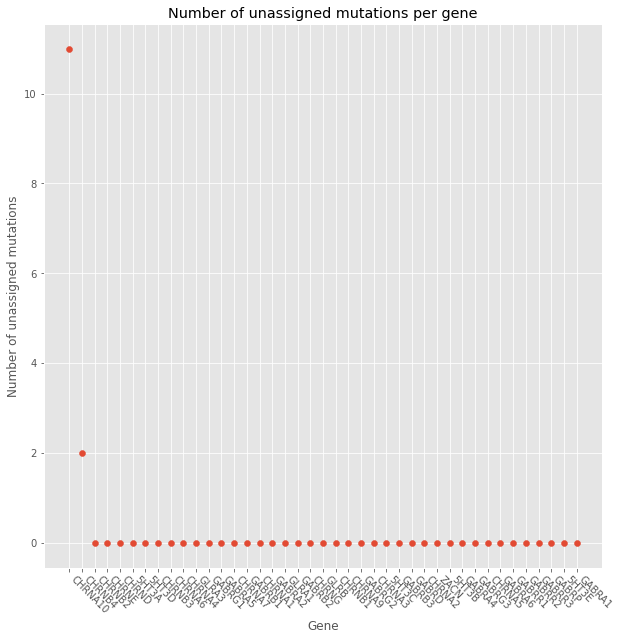

In [374]:
_values["AA Unreferenced"] = _values.apply(lambda x: -sum(missense["AA Referenced"][(missense["AA Referenced"] == -1) & (missense["Gene"] == x["Gene"])]), axis=1)
_values.sort_values(by="AA Unreferenced", ascending=False, inplace=True, ignore_index=True)

pyplot.scatter(_values["Gene"], _values["AA Unreferenced"])
pyplot.xticks(rotation=-45, horizontalalignment="left")
pyplot.xlabel("Gene")
pyplot.ylabel("Number of unassigned mutations")
pyplot.title("Number of unassigned mutations per gene")
pyplot.show()

Let's see how this translates into the proportion of the individual gene mutations that are unasigned.

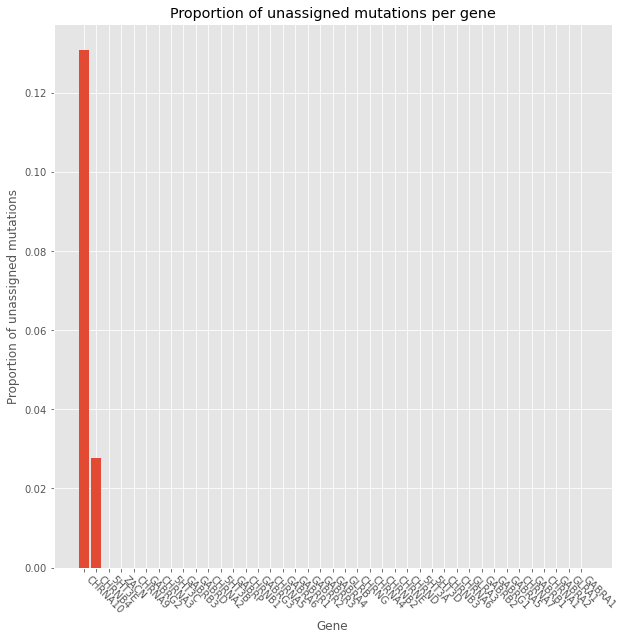

In [375]:
_values["AA Unreferenced"] = _values.apply(lambda x: -sum(missense["AA Referenced"][(missense["AA Referenced"] == -1) & (missense["Gene"] == x["Gene"])]) / sum(missense["Gene"] == x["Gene"]), axis=1)
_values.sort_values(by="AA Unreferenced", ascending=False, inplace=True, ignore_index=True)

pyplot.bar(_values["Gene"], _values["AA Unreferenced"])
pyplot.xticks(rotation=-45, horizontalalignment="left")
pyplot.xlabel("Gene")
pyplot.ylabel("Proportion of unassigned mutations")
pyplot.title("Proportion of unassigned mutations per gene")
pyplot.show()

**Note:**

- CHRNA10: has an extra protein coding transcript, which cannot be reliably aligned to the main transcript, so we cannot add it.
- CHRNB4: we already aligned all the transcript we could
- very short sequences (<100 AA) were automatically excluded

We have for now 0.9 % of SNPs where the numbering of amino acid was incorrect. We might reduce this through adding `extra sequences` or through `manual search`. Is the latter one worth it though?

For now we check where we find the variants in the reference sequence. There seem to be several hot spots. Note that the parts without signal don't necessarily mean a spot that is mutation-free, but might be a part of the protein that is tolerating the mutations better.

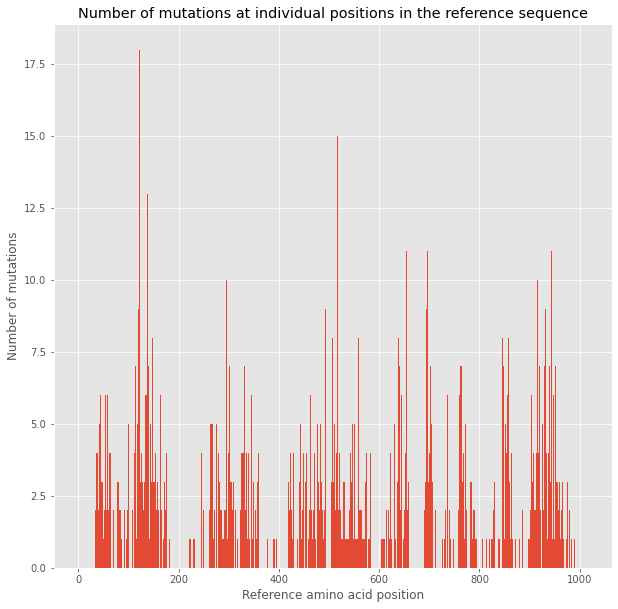

In [376]:
found_missense = missense[missense["AA Referenced"] != -1]
pyplot.hist(found_missense["AA Referenced"], bins=[x for x in range(1, len(alignment[0]))])
pyplot.xlabel("Reference amino acid position")
pyplot.ylabel("Number of mutations")
pyplot.title("Number of mutations at individual positions in the reference sequence")
pyplot.show()

Just in case we will also take only one mutation per amino acid, so we can see where multiple genes get mutated.

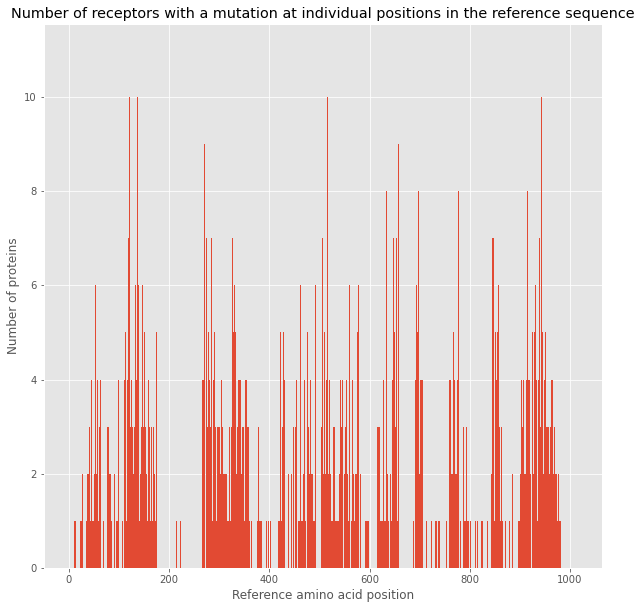

In [377]:
_unique_aas = []
for gene in found_missense["Gene"].unique():
    _unique_aas.extend(found_missense["AA Referenced"][found_missense["Gene"] == gene].unique())
pyplot.hist(_unique_aas, bins=[x for x in range(1, len(alignment[0]))])
pyplot.xlabel("Reference amino acid position")
pyplot.ylabel("Number of proteins")
pyplot.title("Number of receptors with a mutation at individual positions in the reference sequence")
pyplot.show()

# Mapping to structural elements
We have a list of the amino acids involved in the structural elements written in a CSV file. We load them in, transform them to the reference numbering and use them as a reference to annotate the table of mutations.

In [378]:
structural_elements = pandas.read_csv("Structural_elements.csv")
structural_elements

,Gene,AA Name,AA Number,BS
0,GABRA1,Y,252,TM1
1,GABRA1,F,253,TM1
2,GABRA1,V,254,TM1
3,GABRA1,I,255,TM1
4,GABRA1,Q,256,TM1
...,...,...,...,...
394,GABRA1,S,417,ICD
395,GABRA1,K,418,ICD
396,GABRA1,I,419,ICD
397,GABRA1,D,420,ICD


First we need to put our amino acids on the reference sequence. We apply it to every row in the table.

In [379]:
structural_elements["AA Referenced"] = structural_elements.apply(lambda x: ali_class.find_reference(x["Gene"], x["AA Name"], x["AA Number"]) , axis=1)
structural_elements

,Gene,AA Name,AA Number,BS,AA Referenced
0,GABRA1,Y,252,TM1,521
1,GABRA1,F,253,TM1,522
2,GABRA1,V,254,TM1,523
3,GABRA1,I,255,TM1,524
4,GABRA1,Q,256,TM1,525
...,...,...,...,...,...
394,GABRA1,S,417,ICD,939
395,GABRA1,K,418,ICD,940
396,GABRA1,I,419,ICD,941
397,GABRA1,D,420,ICD,942


We convert different structural elements to ranges by finding their minimum and maximum number. We use these to apply ranges to the data table. This way each variant in the data table has a structural element assigned to it. Note the structural elements don't overlap. Furthermore, the transmembrane domain is separated into it's 4 alpha helices. We can also see that some variants remain unclassified. 

In [380]:
found_missense["Region"] = ""
for element in structural_elements["BS"].unique():
    found_missense.at[(found_missense["AA Referenced"] > min(structural_elements["AA Referenced"][structural_elements["BS"] == element])) & (found_missense["AA Referenced"] < max(structural_elements["AA Referenced"][structural_elements["BS"] == element])), "Region"] = element

found_missense["Region"].unique()

C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



array(['', 'TM4', 'ICD', 'ECD', 'TM1', 'TM3', 'TM2'], dtype=object)

In [381]:
found_missense[found_missense["Region"] == "TM1"]

,level_0,index,Chromosome,Position,rsIDs,Reference,Alternate,Source,Filters - exomes,Filters - genomes,...,Hemizygote Count African/African-American,Allele Count European (non-Finnish),Allele Number European (non-Finnish),Homozygote Count European (non-Finnish),Hemizygote Count European (non-Finnish),Gene,AA Number,AA Relative,AA Referenced,Region
56,897,902,5,170808671.0,rs373064332,G,A,gnomAD Genomes,NaN,PASS,...,0.0,1.0,68004.0,0.0,0.0,GABRP,251,0.570455,528,TM1
57,903,908,5,170808690.0,rs757852678,T,C,gnomAD Genomes,NaN,PASS,...,0.0,0.0,68038.0,0.0,0.0,GABRP,257,0.584091,534,TM1
58,909,914,5,170808698.0,rs1455054815,T,C,gnomAD Genomes,NaN,PASS,...,0.0,0.0,68048.0,0.0,0.0,GABRP,260,0.590909,537,TM1
172,2626,2633,2,232530091.0,rs1382082125,G,A,gnomAD Genomes,NaN,PASS,...,0.0,0.0,68012.0,0.0,0.0,CHRND,258,0.499033,531,TM1
277,3816,3831,4,157143893.0,rs199840817,A,G,gnomAD Genomes,NaN,PASS,...,0.0,8.0,68020.0,0.0,0.0,GLRB,280,0.563380,533,TM1
323,4764,4779,8,42732056.0,rs750463267,T,C,gnomAD Genomes,NaN,PASS,...,0.0,7.0,68024.0,0.0,0.0,CHRNB3,250,0.545852,536,TM1
376,5377,5925,17,7448722.0,rs751045224,G,A,gnomAD Genomes,NaN,PASS,...,0.0,4.0,68040.0,0.0,0.0,CHRNB1,252,0.502994,526,TM1
498,7174,8119,3,184105793.0,rs200508262,A,G,gnomAD Genomes,NaN,PASS,...,0.0,1.0,68022.0,0.0,0.0,5HT3E,250,0.548246,522,TM1
657,8794,9764,17,4901011.0,rs762509943,C,A,gnomAD Genomes,NaN,PASS,...,0.0,6.0,68040.0,0.0,0.0,CHRNE,261,0.529412,540,TM1
796,11185,12163,2,232543014.0,rs139998228,T,A,gnomAD Genomes,NaN,PASS,...,0.0,5.0,68032.0,0.0,0.0,CHRNG,246,0.475822,524,TM1


Let's first check how the variants are distributed in different structural elements. We will visualize individual TM helices, but also include a sum of them as a full TM domain.

In [382]:
region_count = Counter(found_missense["Region"])
region_count["TM"] = sum([region_count[key] for key in region_count.keys() if key.startswith("TM")])
region_count = pandas.DataFrame.from_dict({"Region": ["Unassigned", *list(region_count.keys())[1:]], "Count": region_count.values()})

# Finding lengths of individual segments
region_count["Length"] = 0
region_count["Length"] = region_count.apply(lambda y: (structural_elements["AA Referenced"][structural_elements["BS"] == y["Region"]]).max() - (structural_elements["AA Referenced"][structural_elements["BS"] == y["Region"]]).min(), axis=1)
# Summing up all the TMD segments
region_count.at[7, "Length"] = region_count["Length"][region_count["Region"].str.startswith("TM")].sum()
# Finding the length of the unassigned segments
region_count.at[0, "Length"] = len(alignment[0]) - region_count["Length"].sum()

# Normalizing to the lengths
region_count["Relative"] = region_count["Count"] / region_count["Length"]

region_count

,Region,Count,Length,Relative
0,Unassigned,279,118.0,2.364407
1,TM4,68,21.0,3.238095
2,ICD,624,304.0,2.052632
3,ECD,859,424.0,2.025943
4,TM1,33,21.0,1.571429
5,TM3,42,21.0,2.000000
6,TM2,50,21.0,2.380952
7,TM,193,84.0,2.297619


We first plot the total number of variants in each segment.

In [383]:
matplotlib.rcParams["figure.figsize"] = (10, 10)

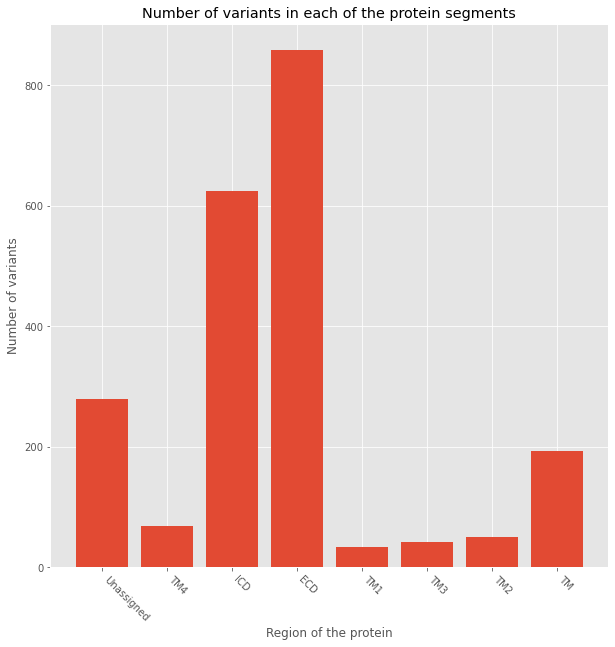

In [384]:
pyplot.bar(region_count["Region"], region_count["Count"])
pyplot.xticks(rotation=-45, horizontalalignment="left")
pyplot.xlabel("Region of the protein")
pyplot.ylabel("Number of variants")
pyplot.title("Number of variants in each of the protein segments")
pyplot.show()

Next we visualize the relative number of variants per segment. For this we divided the total number of variants in each segment with its length. As the last column we also add in a blue color data for the full length of the reference sequence.  

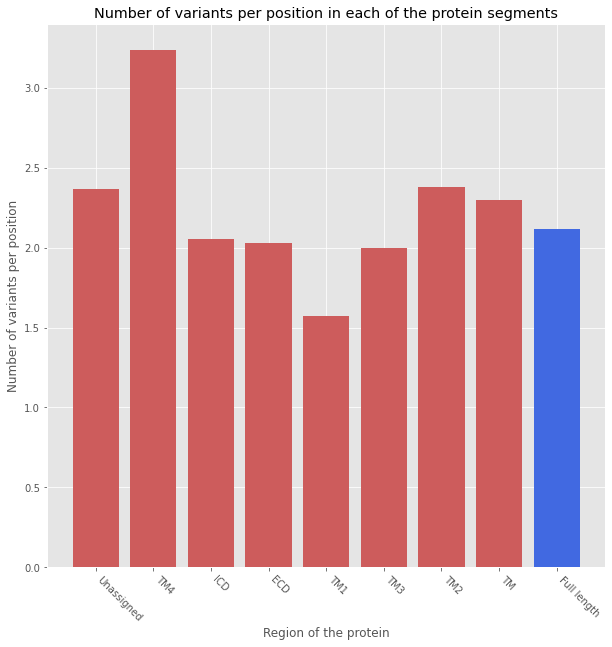

In [385]:
pyplot.bar(region_count["Region"], region_count["Relative"], color="indianred")
pyplot.bar(["Full length"], [region_count["Count"].sum()/region_count["Length"].sum()], color="royalblue")
pyplot.xticks(rotation=-45, horizontalalignment="left")
pyplot.xlabel("Region of the protein")
pyplot.ylabel("Number of variants per position")
pyplot.title("Number of variants per position in each of the protein segments")
pyplot.show()

Next we will count the number of variants on each position in the reference sequence.

In [386]:
x = missense["AA Referenced"][~missense["AA Referenced"].isna()]
x = x[x != -1]
# Spawning every position with a default value (0.0) if it does not exist
x = defaultdict(float, Counter(x))
for i in range(1, len(alignment[0])+1):
    x[i]
x = pandas.DataFrame.from_dict({"AA Referenced":x.keys(), "Count":x.values()})
x

,AA Referenced,Count
0,970,2.0
1,968,3.0
2,958,3.0
3,951,7.0
4,931,9.0
...,...,...
1009,1010,0.0
1010,1011,0.0
1011,1012,0.0
1012,1013,0.0


Asigning regions to the segments.

In [387]:
# Annotating regions
x["Region"] = ""
for element in structural_elements["BS"].unique():
    x["Region"][(x["AA Referenced"] > min(structural_elements["AA Referenced"][structural_elements["BS"] == element])) & (x["AA Referenced"] < max(structural_elements["AA Referenced"][structural_elements["BS"] == element]))] = element
x

C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,AA Referenced,Count,Region
0,970,2.0,
1,968,3.0,
2,958,3.0,TM4
3,951,7.0,TM4
4,931,9.0,ICD
...,...,...,...
1009,1010,0.0,
1010,1011,0.0,
1011,1012,0.0,
1012,1013,0.0,


In [388]:
# Checking the number of amino acids present per position in the alignment
positional_count = numpy.array([len(alignment[:, i].replace("-", "")) for i in range(0, len(alignment[0]))])
positional_count

array([1, 1, 1, ..., 1, 1, 1])

The majority of the positions is occupied by a single sequence. We should probably discard those. Note though that they could be just a single position. In that case we will probably want to retain them.

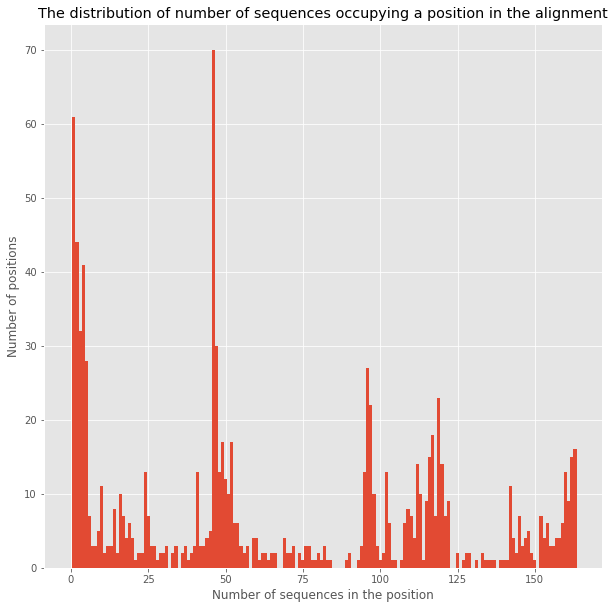

In [389]:
pyplot.hist(positional_count, bins = range(0, max(positional_count)), lw=0, align="left", )
pyplot.title("The distribution of number of sequences occupying a position in the alignment")
pyplot.xlabel("Number of sequences in the position")
pyplot.ylabel("Number of positions")
pyplot.show()

First though we want to also check on the single-sequence positions how many mutations map there.

In [390]:
positional_variants = numpy.array([(found_missense["AA Referenced"] == i).sum() for i in range(0, len(alignment[0]))])
print(((positional_variants > 0) & (positional_count == 1)).sum())
print((positional_count == 1).sum())

3
61


So the majority of the single-sequence positions don't have any mutation mapped. Thus, we will be better served if we disregard them. For each position with a single amino acid in it we will discard it if the neighboring positions also have a single amino acid. So we first compute a mask, which we then apply to the whole sequence.

In [391]:
ali_class.filter_sequence()

found_missense["AA Referenced_filtered"] = found_missense.apply(lambda y: ali_class.convert_to_filtered(y["AA Referenced"]), axis=1)
found_missense

C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,level_0,index,Chromosome,Position,rsIDs,Reference,Alternate,Source,Filters - exomes,Filters - genomes,...,Allele Count European (non-Finnish),Allele Number European (non-Finnish),Homozygote Count European (non-Finnish),Hemizygote Count European (non-Finnish),Gene,AA Number,AA Relative,AA Referenced,Region,AA Referenced_filtered
0,25,25,5,151822692.0,rs752781486,T,C,gnomAD Genomes,NaN,PASS,...,0.0,68040.0,0.0,0.0,GLRA1,444,0.971554,970,,938
1,27,27,5,151822698.0,rs200130685,C,T,gnomAD Genomes,NaN,PASS,...,9.0,68036.0,0.0,0.0,GLRA1,442,0.967177,968,,936
2,33,33,5,151822727.0,rs141039714,C,A,gnomAD Genomes,NaN,PASS,...,0.0,68034.0,0.0,0.0,GLRA1,432,0.945295,958,TM4,926
3,34,34,5,151822728.0,rs1284734503,A,G,gnomAD Genomes,NaN,PASS,...,0.0,68028.0,0.0,0.0,GLRA1,432,0.945295,958,TM4,926
4,36,36,5,151822749.0,rs747623314,A,G,gnomAD Genomes,NaN,PASS,...,3.0,68040.0,0.0,0.0,GLRA1,425,0.929978,951,TM4,919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1963,26804,28691,4,46123822.0,rs564894450,T,C,gnomAD Genomes,NaN,PASS,...,0.0,68004.0,0.0,0.0,GABRG1,31,0.066667,54,,43
1964,26812,28699,4,46123859.0,rs770228084,T,C,gnomAD Genomes,NaN,PASS,...,5.0,68012.0,0.0,0.0,GABRG1,19,0.040860,42,,31
1965,26813,28700,4,46123866.0,rs148202098,A,T,gnomAD Genomes,NaN,PASS,...,18.0,68006.0,0.0,0.0,GABRG1,16,0.034409,39,,28
1966,26818,28705,4,46123877.0,rs140068403,G,T,gnomAD Genomes,NaN,PASS,...,29.0,68012.0,0.0,0.0,GABRG1,13,0.027957,36,,25


How many missense variants do we loose? Out of 1955 we further loose 15. Not a bad figure. 

In [392]:
sum(found_missense["AA Referenced_filtered"] == -1)

2

In [393]:
found_missense[["Gene", "Allele Count", "Region", "AA Referenced"]][found_missense["AA Referenced_filtered"] == -1]

,Gene,Allele Count,Region,AA Referenced
712,GABRB3,173.0,,11
1358,GABRG2,6.0,ICD,687


How many positions in the reference alignment did we discard?

In [394]:
print(sum([y == -1 for y in ali_class.precomputed_filter]))
print(len(ali_class.precomputed_filter))

57
1014


What if we would do the same, but regard isoforms of a individual gene as one?

In [395]:
ali_class.filter_sequence(group_isoforms=True)

found_missense["AA Referenced_filtered_grouped"] = found_missense.apply(lambda y: ali_class.convert_to_filtered(y["AA Referenced"]), axis=1)
print(f"Number of discarded variants: {sum(found_missense['AA Referenced_filtered_grouped'] == -1)}")
found_missense[["Gene", "Allele Count", "Region", "AA Referenced"]][found_missense["AA Referenced_filtered_grouped"] == -1]

Number of discarded variants: 2


C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Gene,Allele Count,Region,AA Referenced
712,GABRB3,173.0,,11
1358,GABRG2,6.0,ICD,687


In [396]:
print(f"Number of discarded positions in the alignment: {sum([y == -1 for y in ali_class.precomputed_filter])}")
print(f"Initial length of the alignment: {len(ali_class.precomputed_filter)}")

Number of discarded positions in the alignment: 78
Initial length of the alignment: 1014


So we ultimately discard more positions if we group the isoforms together, but this only results in a loss of one variant.

Plotting a histogram of variant counts. X axis is thus number of variants on a single position, while y axis represents number of positions with a certain number of variants.

In [397]:
matplotlib.rcParams["figure.figsize"] = (30, 10)

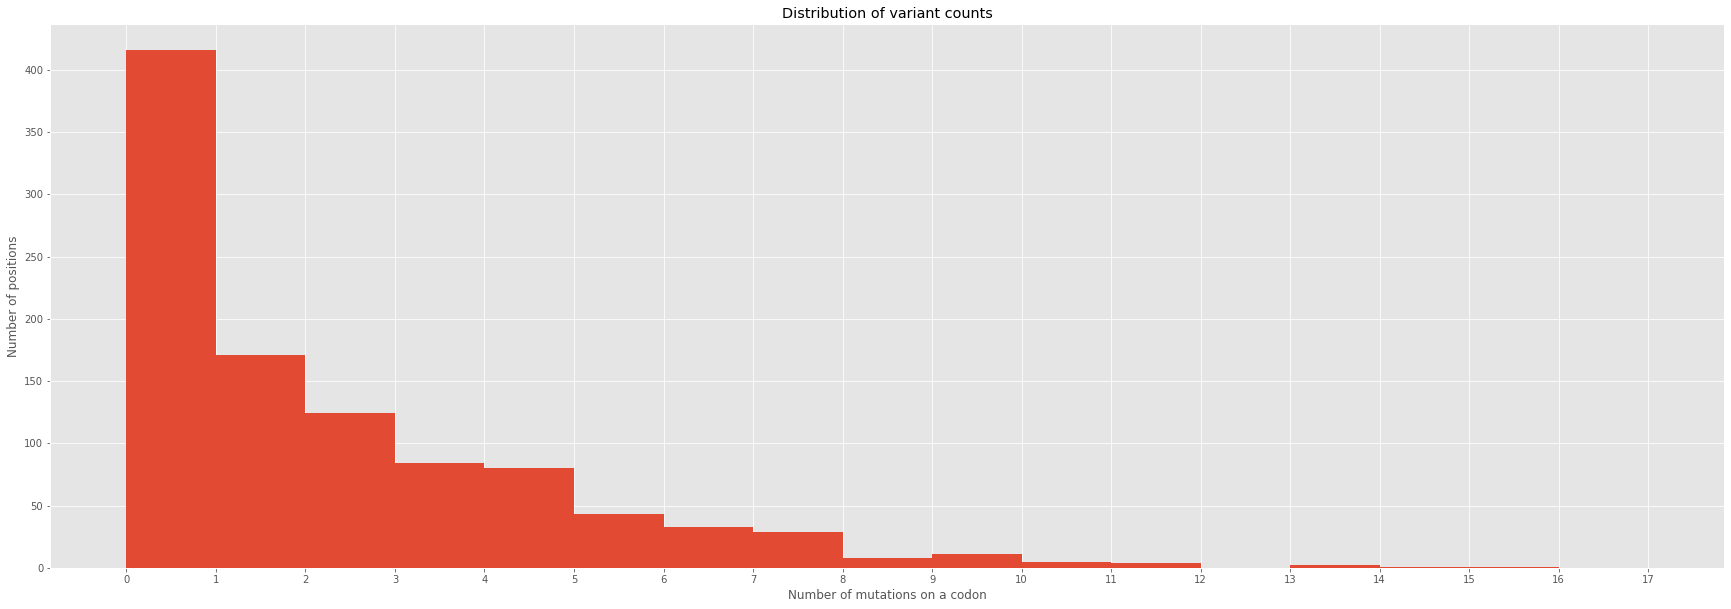

In [398]:
pyplot.hist(x["Count"], bins = range(0, int(max(x["Count"]))))
pyplot.xticks(range(0, int(max(x["Count"]))))
pyplot.title("Distribution of variant counts")
pyplot.xlabel("Number of mutations on a codon")
pyplot.ylabel("Number of positions")
pyplot.show()

Next we divide the variant counts based on the structural elements.

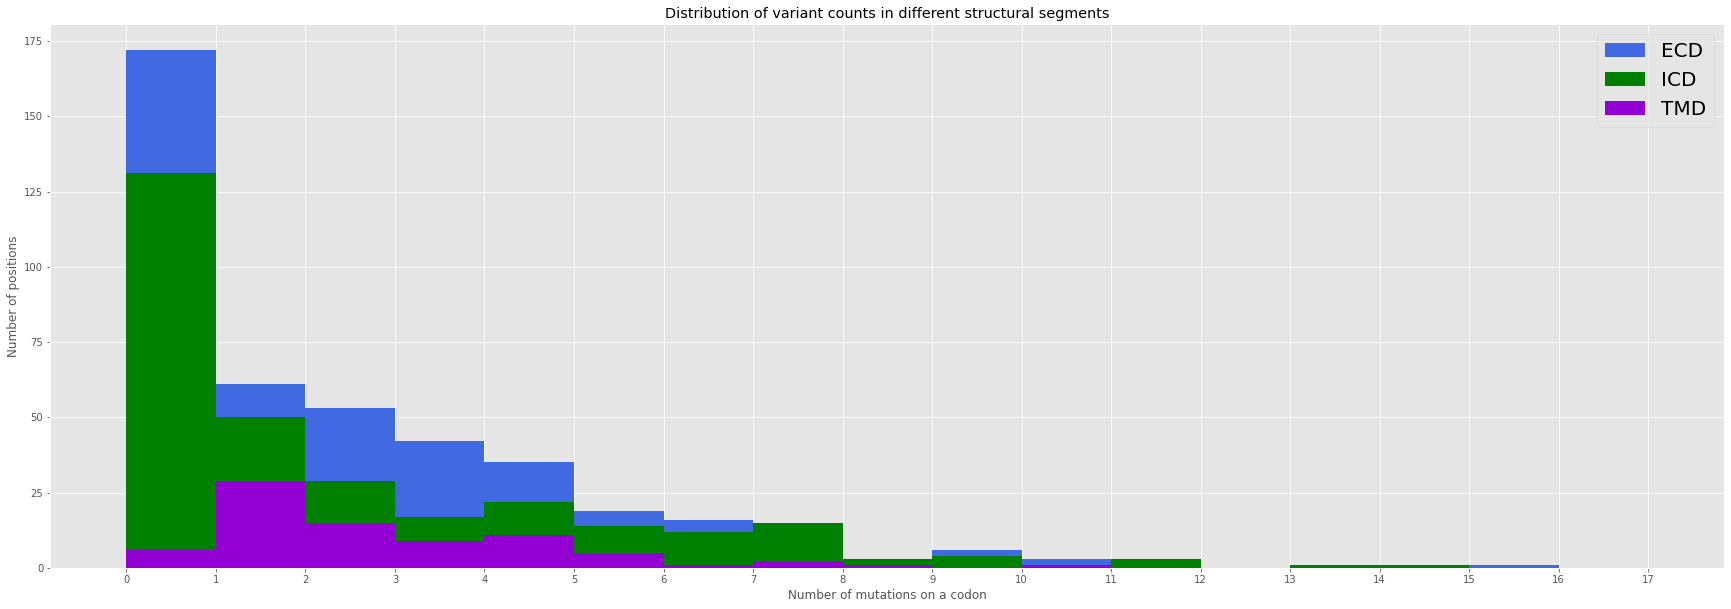

In [399]:
pyplot.hist(x["Count"][x["Region"] == "ECD"], bins = range(0, int(max(x["Count"]))), color="royalblue", lw=0, label="ECD")
pyplot.hist(x["Count"][x["Region"] == "ICD"], bins = range(0, int(max(x["Count"]))), color="green", lw=0, label="ICD")
pyplot.hist(x["Count"][x["Region"].isin(("TM1", "TM2", "TM3", "TM4"))], bins = range(0, int(max(x["Count"]))), color="darkviolet", lw=0, label="TMD")
pyplot.title("Distribution of variant counts in different structural segments")
pyplot.xticks(range(0, int(max(x["Count"]))))
pyplot.xlabel("Number of mutations on a codon")
pyplot.ylabel("Number of positions")
pyplot.legend(prop={"size": 20})
pyplot.show()

We normalize to the length of the segments and produce first an overlaid histogram and then separate histograms for different structural elements.

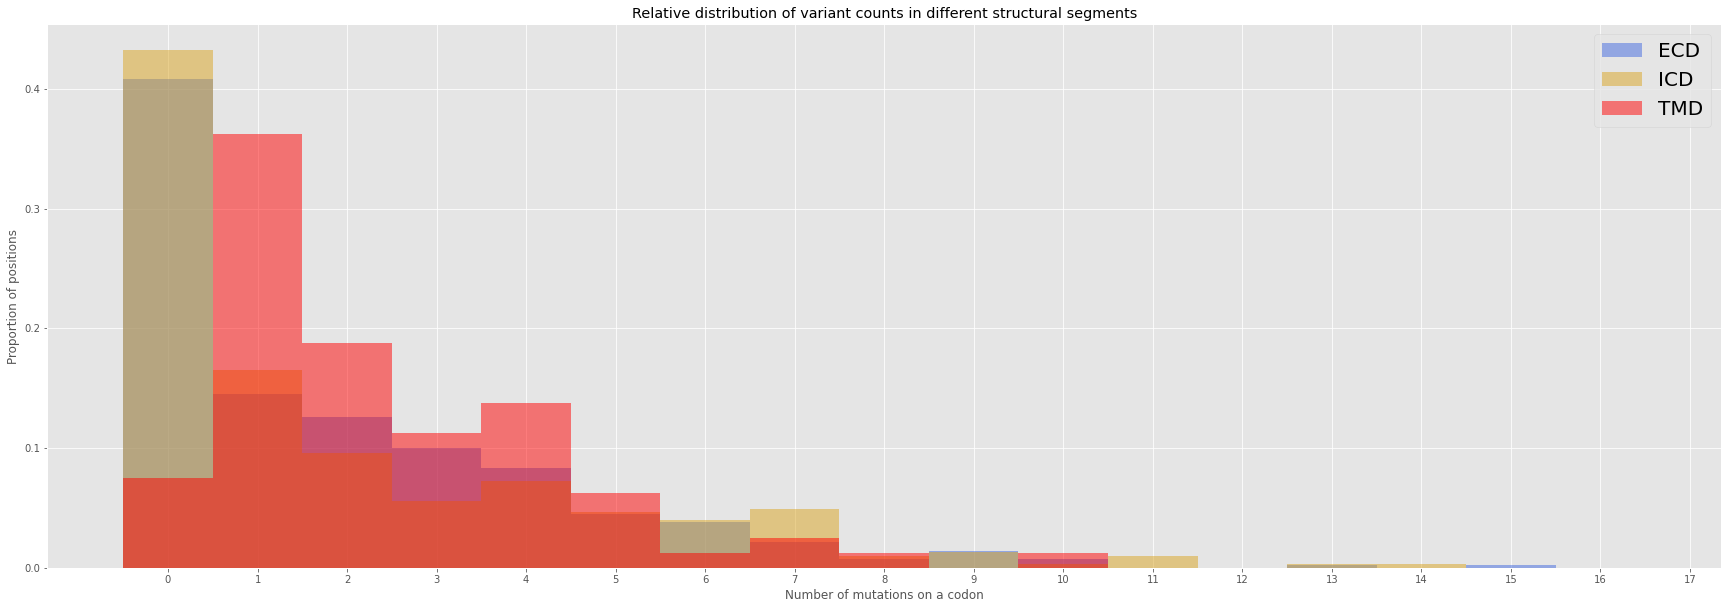

In [400]:
pyplot.hist(x["Count"][x["Region"] == "ECD"], bins = range(0, int(max(x["Count"]))), color="royalblue", lw=0, label="ECD", density=True, align="left", alpha=0.5)
pyplot.hist(x["Count"][x["Region"] == "ICD"], bins = range(0, int(max(x["Count"]))), color="goldenrod", lw=0, label="ICD", density=True, align="left", alpha=0.5)
pyplot.hist(x["Count"][x["Region"].isin(("TM1", "TM2", "TM3", "TM4"))], bins = range(0, int(max(x["Count"]))), color="red", lw=0, label="TMD", density=True, align="left", alpha=0.5)
pyplot.title("Relative distribution of variant counts in different structural segments")
pyplot.xticks(range(0, int(max(x["Count"]))))
pyplot.xlabel("Number of mutations on a codon")
pyplot.ylabel("Proportion of positions")
pyplot.legend(prop={"size": 20})
pyplot.show()


Splitting the histograms

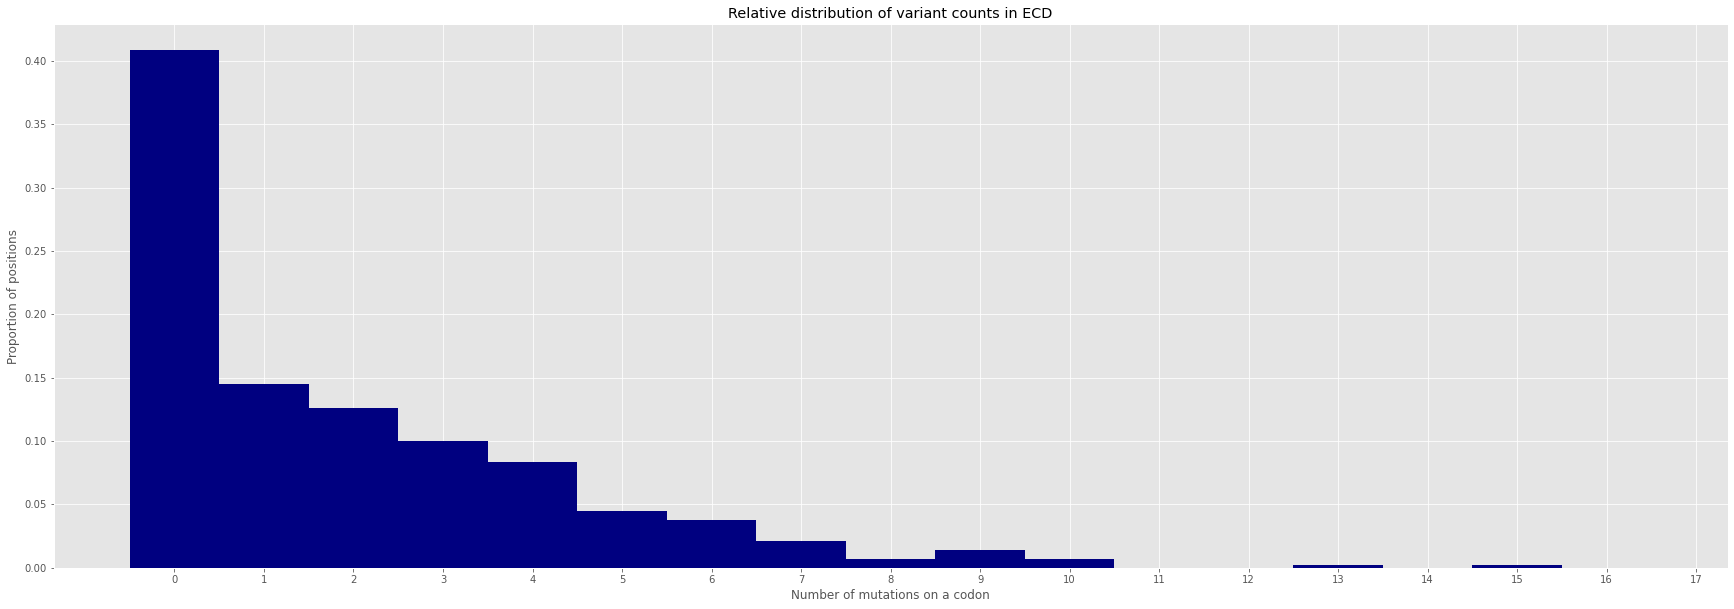

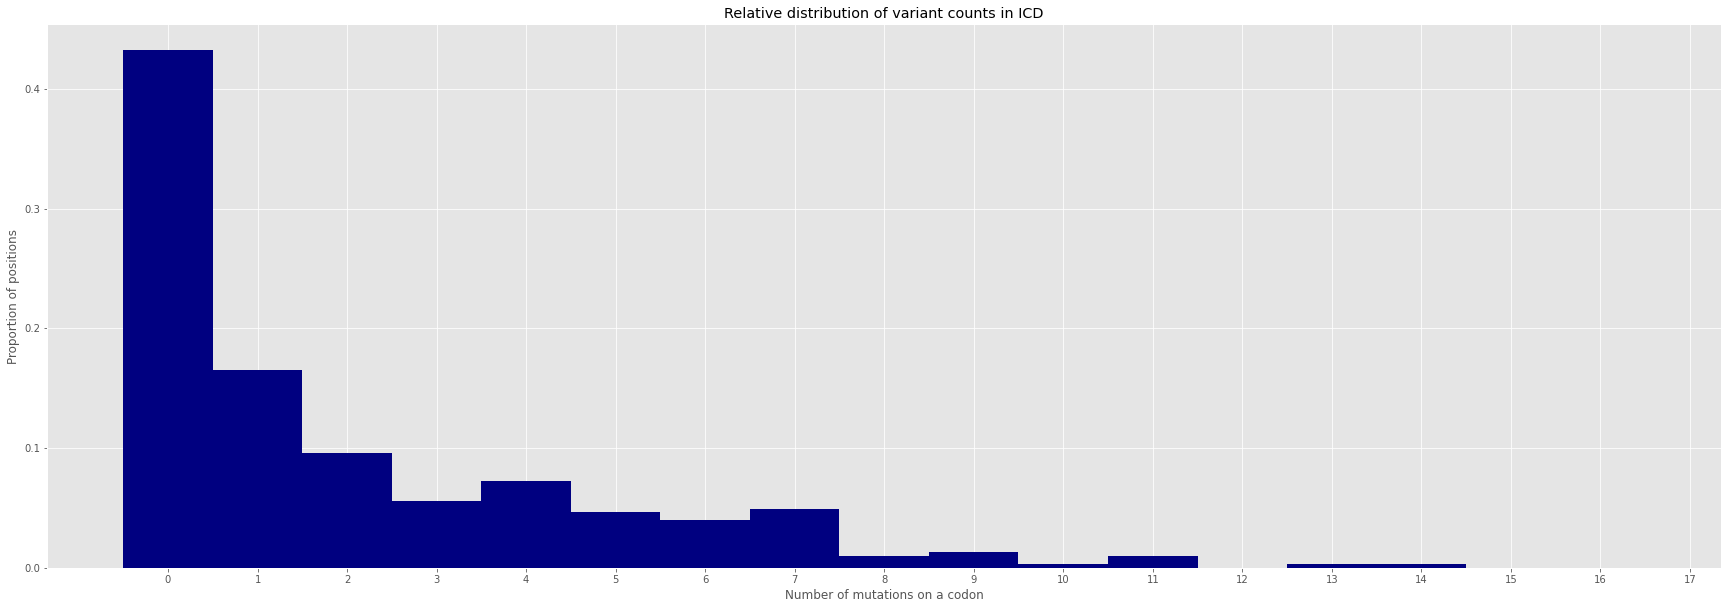

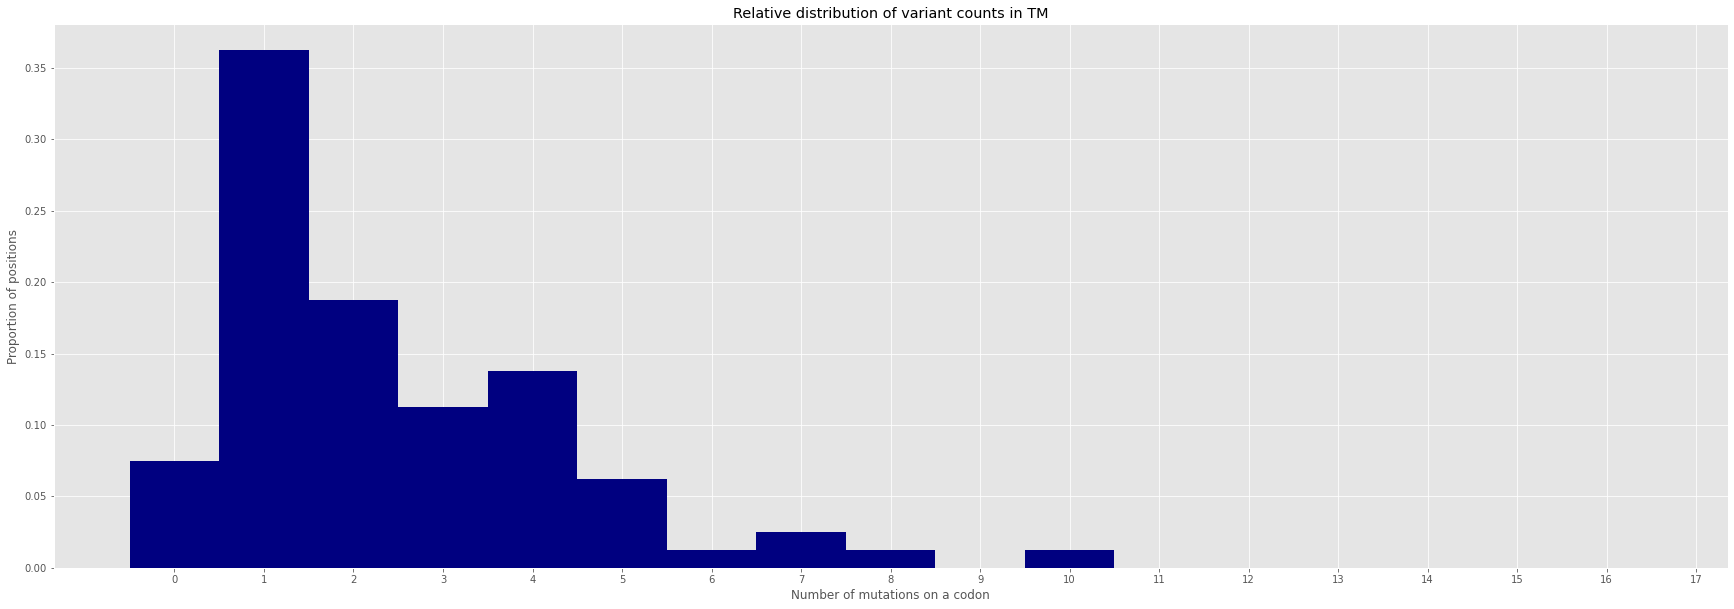

In [401]:
for y in (("ECD",), ("ICD",), ("TM1", "TM2", "TM3", "TM4")):
    pyplot.hist(x["Count"][x["Region"].isin(y)], bins = range(0, int(max(x["Count"]))), color="navy", lw=0, density=True, align="left")
    pyplot.xticks(range(0, int(max(x["Count"]))))
    pyplot.title(f"Relative distribution of variant counts in {y[0].split('1')[0]}")
    pyplot.xlabel(f"Number of mutations on a codon")
    pyplot.ylabel("Proportion of positions")
    pyplot.show()

## Looking at the binding sites

We have the annotation for different binding sites. We first load this data into a data frame and check it. We see that we have each position in the binding sites linked to three different sequences. For our purpose we will use GABRA1 from AlphaFold. This sequence is taken from UniProt and so we are sure we have it in our reference alignment.

In [402]:
binding_sites = pandas.read_csv("Binding_sites_numbering.csv")
binding_sites

,BS,GABRA1_Alphafold,6X40_D,5VDH_D
0,1 (AM_3607),D54,D27,D25
1,1 (AM_3607),N55,N28,A26
2,1 (AM_3607),R56,R29,R27
3,1 (AM_3607),L57,L30,I28
4,1 (AM_3607),R58,R31,R29
...,...,...,...,...
123,5 (PS Site),S423,S325,S326
124,5 (PS Site),A426,A328,C329
125,5 (PS Site),F427,F329,F330
126,6 (PTX Site),V284,V257,A254


First we need to separate the amino acid abbreviation from the numbering. We store these into separate columns.

In [403]:
binding_sites["AA"] = binding_sites["GABRA1_Alphafold"].str[0]
binding_sites["AA Number"] = binding_sites["GABRA1_Alphafold"].str[1:]
binding_sites

,BS,GABRA1_Alphafold,6X40_D,5VDH_D,AA,AA Number
0,1 (AM_3607),D54,D27,D25,D,54
1,1 (AM_3607),N55,N28,A26,N,55
2,1 (AM_3607),R56,R29,R27,R,56
3,1 (AM_3607),L57,L30,I28,L,57
4,1 (AM_3607),R58,R31,R29,R,58
...,...,...,...,...,...,...
123,5 (PS Site),S423,S325,S326,S,423
124,5 (PS Site),A426,A328,C329,A,426
125,5 (PS Site),F427,F329,F330,F,427
126,6 (PTX Site),V284,V257,A254,V,284


Next we want to convert the number into the number in the reference sequence. First we couble check if the function accepts our input. Then we perform the search for each row in the table. 

In [404]:
ali_class.find_reference("GABRA1", binding_sites.iloc[0]["AA"], int(binding_sites.iloc[0]["AA Number"]))

133

In [405]:
binding_sites["AA Referenced"] = binding_sites.apply(lambda y: ali_class.find_reference("GABRA1", y["AA"], int(y["AA Number"])), axis=1)
binding_sites

,BS,GABRA1_Alphafold,6X40_D,5VDH_D,AA,AA Number,AA Referenced
0,1 (AM_3607),D54,D27,D25,D,54,133
1,1 (AM_3607),N55,N28,A26,N,55,134
2,1 (AM_3607),R56,R29,R27,R,56,135
3,1 (AM_3607),L57,L30,I28,L,57,136
4,1 (AM_3607),R58,R31,R29,R,58,137
...,...,...,...,...,...,...,...
123,5 (PS Site),S423,S325,S326,S,423,945
124,5 (PS Site),A426,A328,C329,A,426,948
125,5 (PS Site),F427,F329,F330,F,427,949
126,6 (PTX Site),V284,V257,A254,V,284,554


We check next how many amino acids are unassigned. We see there are none.

In [406]:
sum(binding_sites["AA Referenced"] == -1)

0

## Checking TMD binding sites

We first check which binding sites we have the annotation for. As we can see this is the case for 7 binding sites.

In [407]:
binding_sites["BS"].unique()

array(['1 (AM_3607)', '2 (BZD/Ortho)', '3 (upperTMD)',
       '3.5 (upperTMD - IVM)', '4 (interface steroid site)',
       '5 (PS Site)', '6 (PTX Site)'], dtype=object)

Of all the binding sites we have the annotation for three TMD sites. We will first put them into a list for easier handling later on.

In [408]:
bs_interest = ["3 (upperTMD)", "3.5 (upperTMD - IVM)", "4 (interface steroid site)"]


### Upper TMD site - site 3

We first check site 3 (first in the list). We filter the missense mutations we could put on the reference sequence so we retain only the mutations on the positions linked to the binding site.

In [409]:
site_data = found_missense[found_missense["AA Referenced"].isin(binding_sites["AA Referenced"][binding_sites["BS"] == bs_interest[0]])]
site_data.head()

,level_0,index,Chromosome,Position,rsIDs,Reference,Alternate,Source,Filters - exomes,Filters - genomes,...,Allele Number European (non-Finnish),Homozygote Count European (non-Finnish),Hemizygote Count European (non-Finnish),Gene,AA Number,AA Relative,AA Referenced,Region,AA Referenced_filtered,AA Referenced_filtered_grouped
56,897,902,5,170808671.0,rs373064332,G,A,gnomAD Genomes,NaN,PASS,...,68004.0,0.0,0.0,GABRP,251,0.570455,528,TM1,517,509
60,959,964,5,170809612.0,rs79997355,C,T,gnomAD Genomes,NaN,PASS,...,68032.0,0.0,0.0,GABRP,293,0.665909,571,,560,552
277,3816,3831,4,157143893.0,rs199840817,A,G,gnomAD Genomes,NaN,PASS,...,68020.0,0.0,0.0,GLRB,280,0.563380,533,TM1,522,514
278,3859,3874,4,157152750.0,rs762044849,T,A,gnomAD Genomes,NaN,PASS,...,68026.0,0.0,0.0,GLRB,313,0.629779,567,TM2,556,548
327,4778,4793,8,42732133.0,rs369679759,A,G,gnomAD Genomes,NaN,PASS,...,68030.0,0.0,0.0,CHRNB3,276,0.602620,564,TM2,553,545


Next we use this filtered data to count the number of variants for each gene and each position in the binding site. This way we get a 2D list which we can use to make a heatmap. 

In [410]:
genes = site_data["Gene"]
genes = genes.sort_values(ascending=False, ignore_index=True)
aacids = binding_sites["AA Referenced"][binding_sites["BS"] == bs_interest[0]]
data = [[sum((site_data["Gene"] == gene) & (site_data["AA Referenced"] == aa)) for aa in aacids] for gene in genes]
print(data)

[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0], [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0], [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0], [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0], [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0

In [411]:
fig = go.Figure(data=go.Heatmap(
    z = data,
    x=[str(int(aa)) for aa in aacids],
    y=genes,
    hoverongaps=False
))
fig.update_layout(
    title=f"{bs_interest[0]} binding site",
    xaxis_title = "Referenced amino acid position",
    yaxis_title = "Gene"
)
fig.show()

We repeat this procedure, but instead of counting the number of variants, we sum up the allele counts. This gives us the information on how much the variants at each position are propagated throughout the population in each gene.

In [412]:
genes = site_data["Gene"]
genes = genes.sort_values(ascending=False, ignore_index=True)
aacids = binding_sites["AA Referenced"][binding_sites["BS"] == bs_interest[0]]
data = [[sum(site_data["Allele Count"][(site_data["Gene"] == gene) & (site_data["AA Referenced"] == aa)]) for aa in aacids] for gene in genes]
print(data)

[[0, 11.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 10.0, 0, 0, 0, 4.0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 10.0, 0, 0, 0, 4.0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4.0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 69.0, 4.0, 0, 5.0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 69.0, 4.0, 0, 5.0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 69.0, 4.0, 0, 5.0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 10.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1505.0, 0, 0, 0, 0, 0], [0, 0, 10.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1505.0, 0, 0, 0, 0, 0], [0, 0, 4.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 29.0, 0, 0, 0, 10.0, 152.0, 0, 0, 0, 0, 0, 7.0, 0, 12.0, 0, 0, 0], [0, 29.0, 0, 0, 0, 10.0, 152.0, 0, 0, 0, 0, 0, 7.0, 0, 12.0, 0, 0, 0], [0, 29.0, 0, 0, 0, 10.0, 152.0, 0, 0, 0, 0, 0, 7.0, 0, 12.0, 0, 0, 0], [0, 29.0, 0, 0, 0, 10.0, 152.0, 0, 0, 0, 0, 0, 7.0, 0, 12.0, 0, 0, 0], [0, 29.0, 0, 0, 0, 10.0, 152.0, 0, 0, 0, 0, 0, 7.0, 0, 12.0, 0, 0, 0], [6.0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [413]:
fig = go.Figure(data=go.Heatmap(
    z = data,
    x=[str(int(aa)) for aa in aacids],
    y=genes,
    hoverongaps=False
))
fig.update_layout(
    title=f"{bs_interest[0]} binding site - Sum of allele counts",
    xaxis_title = "Referenced amino acid position",
    yaxis_title = "Gene"
)
fig.show()

### Upper TMD IVM site - site 3.5

We repeat completely the same analysis for the site 3.5.

In [414]:
site_data = found_missense[found_missense["AA Referenced"].isin(binding_sites["AA Referenced"][binding_sites["BS"] == bs_interest[1]])]
site_data.head()

,level_0,index,Chromosome,Position,rsIDs,Reference,Alternate,Source,Filters - exomes,Filters - genomes,...,Allele Number European (non-Finnish),Homozygote Count European (non-Finnish),Hemizygote Count European (non-Finnish),Gene,AA Number,AA Relative,AA Referenced,Region,AA Referenced_filtered,AA Referenced_filtered_grouped
172,2626,2633,2,232530091.0,rs1382082125,G,A,gnomAD Genomes,NaN,PASS,...,68012.0,0.0,0.0,CHRND,258,0.499033,531,TM1,520,512
178,2688,2703,2,232531450.0,rs142063328,C,T,gnomAD Genomes,NaN,PASS,...,68008.0,0.0,0.0,CHRND,307,0.593810,615,,604,591
228,3209,3224,4,40349229.0,rs201389718,C,T,gnomAD Genomes,NaN,PASS,...,68030.0,0.0,0.0,CHRNA9,238,0.496868,520,,509,501
276,3805,3820,4,157143854.0,rs142433300,G,A,gnomAD Genomes,NaN,PASS,...,68014.0,0.0,0.0,GLRB,267,0.537223,520,,509,501
648,8665,9635,17,4899553.0,rs146533655,G,A,gnomAD Genomes,NaN,PASS,...,67960.0,0.0,0.0,CHRNE,316,0.640974,629,TM3,618,605


In [415]:
genes = site_data["Gene"]
genes = genes.sort_values(ascending=False, ignore_index=True)
aacids = binding_sites["AA Referenced"][binding_sites["BS"] == bs_interest[1]]
data = [[sum((site_data["Gene"] == gene) & (site_data["AA Referenced"] == aa)) for aa in aacids] for gene in genes]
print(data)

[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 1, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 1, 0, 1], [0, 0, 0, 0, 0, 0, 1, 1, 0, 1], [0, 0, 0, 0, 0, 0, 1, 1, 0, 1], [0, 1, 0, 0, 0, 0, 0, 1, 0, 0], [0, 1, 0, 0, 0, 0, 0, 1, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 0, 0, 0, 1, 0, 0, 0], [1, 1, 0, 0, 0, 0, 1, 0, 0, 0], [1, 1, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]]


In [416]:
fig = go.Figure(data=go.Heatmap(
    z = data,
    x=[str(int(aa)) for aa in aacids],
    y=genes,
    hoverongaps=False
))
fig.update_layout(
    title=f"{bs_interest[1]} binding site",
    xaxis_title = "Referenced amino acid position",
    yaxis_title = "Gene"
)
fig.show()

In [417]:
genes = site_data["Gene"]
genes = genes.sort_values(ascending=False, ignore_index=True)
aacids = binding_sites["AA Referenced"][binding_sites["BS"] == bs_interest[1]]
data = [[sum(site_data["Allele Count"][(site_data["Gene"] == gene) & (site_data["AA Referenced"] == aa)]) for aa in aacids] for gene in genes]
print(data)

[[5.0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 7.0, 6.0, 0, 0, 0], [0, 0, 0, 0, 0, 7.0, 6.0, 0, 0, 0], [0, 0, 0, 5.0, 0, 0, 264.0, 0, 0, 0], [0, 0, 0, 5.0, 0, 0, 264.0, 0, 0, 0], [8.0, 60.0, 0, 0, 0, 0, 0, 0, 0, 0], [8.0, 60.0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 5.0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 64.0, 4.0, 0, 7.0], [0, 0, 0, 0, 0, 0, 64.0, 4.0, 0, 7.0], [0, 0, 0, 0, 0, 0, 64.0, 4.0, 0, 7.0], [0, 5.0, 0, 0, 0, 0, 0, 127.0, 0, 0], [0, 5.0, 0, 0, 0, 0, 0, 127.0, 0, 0], [0, 17.0, 0, 0, 0, 0, 0, 0, 0, 0], [16.0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 20.0, 0, 0, 0, 0, 0, 0, 0], [4.0, 66.0, 0, 0, 0, 0, 6.0, 0, 0, 0], [4.0, 66.0, 0, 0, 0, 0, 6.0, 0, 0, 0], [4.0, 66.0, 0, 0, 0, 0, 6.0, 0, 0, 0], [0, 0, 4.0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 7.0, 0, 0]]


In [418]:
fig = go.Figure(data=go.Heatmap(
    z = data,
    x=[str(int(aa)) for aa in aacids],
    y=genes,
    hoverongaps=False
))
fig.update_layout(
    title=f"{bs_interest[1]} binding site - Sum of allele counts",
    xaxis_title = "Referenced amino acid position",
    yaxis_title = "Gene"
)
fig.show()

### Interface steroid site - site 4

And finally we also perform the analysis on site 4.

In [419]:
site_data = found_missense[found_missense["AA Referenced"].isin(binding_sites["AA Referenced"][binding_sites["BS"] == bs_interest[2]])]
site_data.head()

,level_0,index,Chromosome,Position,rsIDs,Reference,Alternate,Source,Filters - exomes,Filters - genomes,...,Allele Number European (non-Finnish),Homozygote Count European (non-Finnish),Hemizygote Count European (non-Finnish),Gene,AA Number,AA Relative,AA Referenced,Region,AA Referenced_filtered,AA Referenced_filtered_grouped
96,1502,1507,11,113943069.0,rs201779669,T,A,gnomAD Genomes,NaN,PASS,...,68014.0,0.0,0.0,5HT3B,262,0.594104,542,,531,523
104,1559,1564,11,113944617.0,rs762638574,G,A,gnomAD Genomes,NaN,PASS,...,68028.0,0.0,0.0,5HT3B,318,0.721088,633,TM3,622,609
173,2633,2640,2,232530124.0,rs141627135,T,C,gnomAD Genomes,NaN,PASS,...,68020.0,0.0,0.0,CHRND,269,0.520309,542,,531,523
232,3296,3311,4,40354024.0,rs55633891,C,A,gnomAD Genomes,NaN,PASS,...,68014.0,0.0,0.0,CHRNA9,315,0.657620,633,TM3,622,609
233,3297,3312,4,40354024.0,rs55633891,C,T,gnomAD Genomes,NaN,PASS,...,68004.0,586.0,0.0,CHRNA9,315,0.657620,633,TM3,622,609


In [420]:
genes = site_data["Gene"]
genes = genes.sort_values(ascending=False, ignore_index=True)
aacids = binding_sites["AA Referenced"][binding_sites["BS"] == bs_interest[2]]
data = [[sum((site_data["Gene"] == gene) & (site_data["AA Referenced"] == aa)) for aa in aacids] for gene in genes]
print(data)

[[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1], [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 1], [0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 1], [0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 1], [0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 1], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0], [0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0], [0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0], [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 1, 0, 

In [421]:
fig = go.Figure(data=go.Heatmap(
    z = data,
    x=[str(int(aa)) for aa in aacids],
    y=genes,
    hoverongaps=False
))
fig.update_layout(
    title=f"{bs_interest[2]} binding site",
    xaxis_title = "Referenced amino acid position",
    yaxis_title = "Gene"
)
fig.show()

In [422]:
genes = site_data["Gene"]
genes = genes.sort_values(ascending=False, ignore_index=True)
aacids = binding_sites["AA Referenced"][binding_sites["BS"] == bs_interest[2]]
data = [[sum(site_data["Allele Count"][(site_data["Gene"] == gene) & (site_data["AA Referenced"] == aa)]) for aa in aacids] for gene in genes]
print(data)

[[0, 0, 0, 0, 4.0, 0, 0, 0, 5.0, 0, 0], [0, 0, 0, 0, 4.0, 0, 0, 0, 5.0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 25.0, 49.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 25.0, 49.0], [0, 0, 0, 0, 5.0, 0, 0, 6.0, 0, 0, 0], [0, 0, 0, 0, 5.0, 0, 0, 6.0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 62.0], [0, 0, 0, 33.0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 63.0, 0, 0, 12.0, 0, 0, 3692.0], [0, 0, 0, 0, 63.0, 0, 0, 12.0, 0, 0, 3692.0], [0, 0, 0, 0, 63.0, 0, 0, 12.0, 0, 0, 3692.0], [0, 0, 0, 0, 63.0, 0, 0, 12.0, 0, 0, 3692.0], [0, 0, 0, 47.0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 20781.0, 0, 47.0, 0, 0, 0, 0], [0, 0, 0, 0, 20781.0, 0, 47.0, 0, 0, 0, 0], [0, 0, 0, 0, 20781.0, 0, 47.0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 3758.0, 0, 0, 0, 0, 0], [0, 0, 0, 5.0, 132.0, 0, 0, 0, 4.0, 0, 0], [0, 0, 0, 5.0, 132.0, 0, 0, 0, 4.0, 0, 0], [0, 0, 0, 5.0, 132.0, 0, 0, 0, 4.0, 0, 0], [20.0, 0, 0, 0, 0, 4.0, 0, 0, 0, 0, 0], [20.0, 0, 0, 0, 0, 4.0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 6.0, 5.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 6.0, 5.0], [0, 

In [423]:
fig = go.Figure(data=go.Heatmap(
    z = data,
    x=[str(int(aa)) for aa in aacids],
    y=genes,
    hoverongaps=False
))
fig.update_layout(
    title=f"{bs_interest[2]} binding site - Sum of allele counts",
    xaxis_title = "Referenced amino acid position",
    yaxis_title = "Gene"
)
fig.show()

# Extra: Checking H267 and E270 from GABRB3
**Note:** The numbering is without the signal peptide; we add 25 AAs because that is the signal peptide length in GABRB3

In [424]:
aa_referenced = [ali_class.convert_to_reference("GABRB3", "H", 267+25), ali_class.convert_to_reference("GABRB3", "E", 270+25)]
aa_referenced

[569, 572]

In [425]:
subset = missense[missense["AA Referenced"].isin(aa_referenced)]
subset

,level_0,index,Chromosome,Position,rsIDs,Reference,Alternate,Source,Filters - exomes,Filters - genomes,...,Homozygote Count African/African-American,Hemizygote Count African/African-American,Allele Count European (non-Finnish),Allele Number European (non-Finnish),Homozygote Count European (non-Finnish),Hemizygote Count European (non-Finnish),Gene,AA Number,AA Relative,AA Referenced
279,3863,3878,4,157152765.0,rs750803516,G,A,gnomAD Genomes,NaN,PASS,...,0.0,0.0,7.0,68010.0,0.0,0.0,GLRB,318,0.639839,572
329,4783,4798,8,42732158.0,rs75384358,A,G,gnomAD Genomes,NaN,PASS,...,0.0,0.0,0.0,68042.0,0.0,0.0,CHRNB3,284,0.620087,572
398,5790,6697,3,97993001.0,rs749225173,C,T,gnomAD Genomes,NaN,PASS,...,0.0,0.0,0.0,68026.0,0.0,0.0,GABRR3,319,0.683084,572
1232,17010,18515,11,113986680.0,rs759087911,A,T,gnomAD Genomes,NaN,PASS,...,0.0,0.0,0.0,68014.0,0.0,0.0,5HT3A,290,0.606695,569


In [426]:
(subset["Gene"] + "_" + subset["AA Referenced"].astype(int).astype(str)).values.tolist()

['GLRB_572', 'CHRNB3_572', 'GABRR3_572', '5HT3A_569']

In [427]:
matplotlib.rcParams["figure.figsize"] = (10, 10)

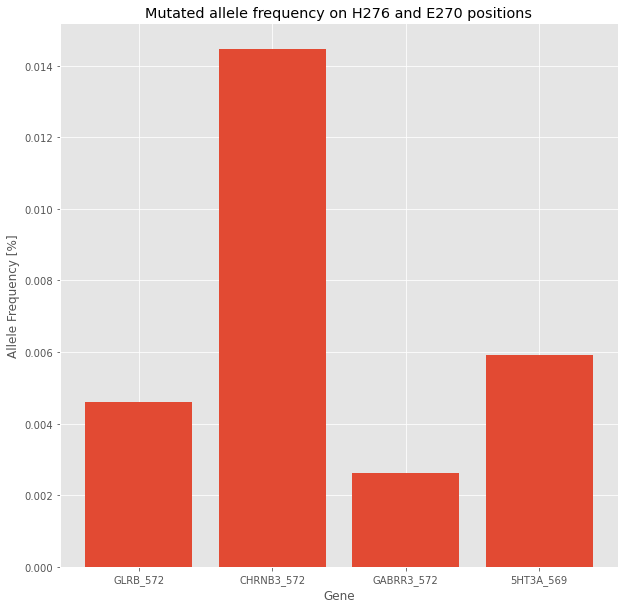

In [428]:
pyplot.bar(subset["Gene"] + "_" + subset["AA Referenced"].astype(int).astype(str), subset["Allele Count"]/subset["Allele Number"]*100)
pyplot.xlabel("Gene")
pyplot.ylabel("Allele Frequency [%]")
pyplot.title("Mutated allele frequency on H276 and E270 positions")
pyplot.show()

**NOTE:**
- GABRB3 H267 = 569
- GABRB3 E270 = 572 

# Coloring the ribbon

In [433]:
print(found_missense["Allele Frequency"].min()*100_000)
print(found_missense["Allele Frequency"].max()*100_000)

2.00443648608
82193.90844236186


In [447]:
output_data = pandas.DataFrame(found_missense[["Gene", "AA Referenced", "Protein Consequence", "Allele Frequency"]])
output_data["Allele Frequency"] = output_data["Allele Frequency"] * 100_000 # Convert to per 100_000 alleles

output_data["Position"] = output_data.apply(lambda y: ali_class.reference_to_aa(y["AA Referenced"], "7EKT.A")[1], axis = 1)
output_data_clean = output_data[output_data["Position"] != -1]
output_data_clean

,Gene,AA Referenced,Protein Consequence,Allele Frequency,Position
0,GLRA1,970,p.Glu444Gly,3.944514,390
1,GLRA1,968,p.Arg442His,6.573844,388
2,GLRA1,958,p.Met432Ile,31.552377,378
3,GLRA1,958,p.Met432Thr,3.286576,378
4,GLRA1,951,p.Met425Thr,2.628155,371
...,...,...,...,...,...
1956,GABRG1,293,p.Ile143Leu,3.287484,85
1957,GABRG1,140,p.Ile83Thr,8.573954,23
1958,GABRG1,137,p.Arg80His,6.598134,20
1959,GABRG1,127,p.Leu72Phe,3.297674,12


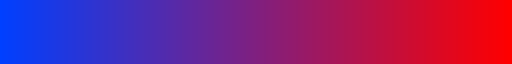

In [226]:
palette = matplotlib.colors.LinearSegmentedColormap.from_list("testCmap", [[0, 64/255, 1], [1, 0, 0]])
palette

In [448]:
output_data_clean["Color"] = numpy.apply_along_axis(matplotlib.colors.rgb2hex, 1, palette((output_data_clean["Allele Frequency"]-output_data_clean["Allele Frequency"].min())*255/output_data_clean["Allele Frequency"].max()))
output_data_clean["Color"] = output_data_clean["Color"].str.replace("#", "0x")
print(output_data_clean)
# print(numpy.apply_along_axis(matplotlib.colors.rgb2hex, 1, palette([0, 255])))
# print(palette([0, 255]))

        Gene  AA Referenced Protein Consequence  Allele Frequency  Position  \
0      GLRA1            970         p.Glu444Gly          3.944514       390   
1      GLRA1            968         p.Arg442His          6.573844       388   
2      GLRA1            958         p.Met432Ile         31.552377       378   
3      GLRA1            958         p.Met432Thr          3.286576       378   
4      GLRA1            951         p.Met425Thr          2.628155       371   
...      ...            ...                 ...               ...       ...   
1956  GABRG1            293         p.Ile143Leu          3.287484        85   
1957  GABRG1            140          p.Ile83Thr          8.573954        23   
1958  GABRG1            137          p.Arg80His          6.598134        20   
1959  GABRG1            127          p.Leu72Phe          3.297674        12   
1960  GABRG1            118          p.Asp63Tyr          5.934796         3   

         Color  
0     0x0140fe  
1     0x033ffc  


C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



All the values should be normalized to 0-255 range!

Index(['level_0', 'index', 'Chromosome', 'Position', 'rsIDs', 'Reference',
       'Alternate', 'Source', 'Filters - exomes', 'Filters - genomes',
       'Transcript', 'HGVS Consequence', 'Protein Consequence',
       'Transcript Consequence', 'VEP Annotation',
       'ClinVar Clinical Significance', 'ClinVar Variation ID', 'Flags',
       'Allele Count', 'Allele Number', 'Allele Frequency', 'Homozygote Count',
       'Hemizygote Count', 'Allele Count Other', 'Allele Number Other',
       'Homozygote Count Other', 'Hemizygote Count Other',
       'Allele Count Latino/Admixed American',
       'Allele Number Latino/Admixed American',
       'Homozygote Count Latino/Admixed American',
       'Hemizygote Count Latino/Admixed American',
       'Allele Count European (Finnish)', 'Allele Number European (Finnish)',
       'Homozygote Count European (Finnish)',
       'Hemizygote Count European (Finnish)', 'Allele Count Amish',
       'Allele Number Amish', 'Homozygote Count Amish',
       'He